 This is the ensemble file listing all the analysis in the paper


In [1]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner

# platform = "jupyter"
# params.confirm_cwd(platform)
model_params = params.model_params
colors = {'blue':'#62a0cb','orange':'#ff7f0e','green':'#2ca02c'}

In [2]:
def select_value(row):
    columns = row.index.tolist()
    if ('death_year' not in columns) or (pd.isnull(row['death_year'])):
        
        if ('deathY' not in columns) or (pd.isnull(row['deathY'])) :
                
            if ('radyear' not in columns) or (pd.isnull(row['radyear']) ):
                if row['death']==1:
                    val = 'Error'
                else:
                    val=None
            else:
                val = row['radyear']
        else:
            val = row['deathY']
    else:
        val = row['death_year']
    
    return val

datasets = {'HRS':'death_year','SHARE':'deathY','ELSA':'radyear','COMB':'death_year'}


# Data Description

In [39]:
# combinde dataset 
for types in range(1,5):
    print(f'type={types}')
    comb,domain_lst = params.read_merged_data(type = types)
    print(f'for this combination, there are {len(domain_lst)} variables, datashape = {comb.shape}')

    domain_name = 'combine_all'
    model_params['domain_dict'][domain_name]=domain_lst
    print(f'there are {len(domain_lst)} vars and they are \n{domain_lst}')
    '''
    for model_name in ['lgb','xgb']:
        print(f'model is {model_name} -----------------')
        model = Models.Model_fixed_test_size(data=comb, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
        print_model_fits(evas=metric(model))

    '''
    comb['death_year']=comb.apply(select_value, axis=1)
    print(f'death Year starts:{comb["death_year"].min()}, ends:{comb["death_year"].max()}')
    


type=1
for this combination, there are 16 variables, datashape = (42778, 89)
there are 16 vars and they are 
['everrent', 'ZwealthT', 'currsmokeYN', 'vigactivityYN', 'Zmotherseduc', 'rocc', 'Zfatherseduc', 'Zeduccat', 'migrantYN', 'eversmokeYN', 'sleepYN', 'everunemployed', 'age', 'everdivorced', 'nevermarried', 'maleYN']
death Year starts:2005.0, ends:2021.0
type=2
for this combination, there are 25 variables, datashape = (35053, 82)
there are 25 vars and they are 
['everrent', 'rocc', 'modactivityYN', 'Zperceivedconstraints', 'everunemployed', 'age', 'nevermarried', 'sumadultAE', 'Zpessimism', 'Zfatherseduc', 'migrantYN', 'eversmokeYN', 'fathersocc', 'ZwealthT', 'Zhopelessness', 'Zmotherseduc', 'Zposaffect', 'sleepYN', 'Zoptimism', 'currsmokeYN', 'vigactivityYN', 'Zeduccat', 'Znegaffect', 'everdivorced', 'maleYN']
death Year starts:2006.0, ends:2021.0
type=3
for this combination, there are 29 variables, datashape = (21300, 81)
there are 29 vars and they are 
['everrent', 'Znegfriends

In [41]:
df_data_description=pd.DataFrame(columns = ['Dataset','Risk Factor Number','Sample Size','Prevalence','Prediction_Window','var set'])
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'All Three Datasets','COMB_2':'HRS+SHARE','COMB_3':'HRS+ELSA','COMB_4':'SHARE + ELSA'}


for dataset in datasets.keys():
    if dataset != 'COMB':
        df = params.data_reader(dataset=dataset,source='us',bio=False)
        if dataset == 'SHARE':
            df = df.loc[(df['deathY']>2005)|( df['death']==0),]
        var_in_dataset = list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
        
        df_data_description.loc[len(df_data_description),]=[dataset,len(var_in_dataset),len(df),round(df['death'].sum()/len(df),3),f'{int(df[datasets[dataset]].min())} - {int(df[datasets[dataset]].max())}',var_in_dataset]    
        del var_in_dataset

    else:
        for i in [1,2,3,4]:
            df,domain_lst = params.read_merged_data(type =i)
            df['death_year']=df.apply(select_value, axis=1)
            
            df_data_description.loc[len(df_data_description),]=[table_name_dict[f'{dataset}_{i}'],len(domain_lst),len(df),round(df['death'].sum()/len(df),3),f'{int(df[datasets[dataset]].min())} - {int(df[datasets[dataset]].max())}',domain_lst]    
            

In [5]:
df_data_description = df_data_description.T.drop(index=['var set']).reset_index()
df_data_description.columns = df_data_description.loc[0,:]
df_data_description = df_data_description.loc[1:,:]


df_data_description_first = df_data_description[['Dataset','HRS','SHARE','ELSA']]
df_data_description_sec = df_data_description[['Dataset','All Three Datasets','HRS+SHARE','HRS+ELSA','SHARE + ELSA']]

## Table 1: Data prev

In [6]:
print(df_data_description_first.to_latex(index=False, caption='Death Window and Prevalence of All Datasets', label='tab:data_pre'))
print()
print(df_data_description_sec.to_latex(index=False, caption='Death Window and Prevalence of All Datasets', label='tab:data_pre'))

\begin{table}
\centering
\caption{Death Window and Prevalence of All Datasets}
\label{tab:data_pre}
\begin{tabular}{llll}
\toprule
           Dataset &         HRS &       SHARE &        ELSA \\
\midrule
Risk Factor Number &          61 &          25 &          29 \\
       Sample Size &       13575 &       21478 &        7725 \\
        Prevalence &         0.3 &       0.195 &       0.054 \\
 Prediction\_Window & 2008 - 2019 & 2006 - 2021 & 2005 - 2012 \\
\bottomrule
\end{tabular}
\end{table}


\begin{table}
\centering
\caption{Death Window and Prevalence of All Datasets}
\label{tab:data_pre}
\begin{tabular}{lllll}
\toprule
           Dataset & All Three Datasets &   HRS+SHARE &    HRS+ELSA & SHARE + ELSA \\
\midrule
Risk Factor Number &                 16 &          25 &          29 &           16 \\
       Sample Size &              42778 &       35053 &       21300 &        29203 \\
        Prevalence &              0.203 &       0.236 &       0.211 &        0.158 \\
 Prediction\_W

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Table S1

In [42]:
var_dict=model_params['var_dict']

In [43]:
df_data_description=pd.DataFrame(columns = ['Dataset','Risk Factors'])
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'HRS+SHARE+ELSA','COMB_2':'HRS+SHARE','COMB_3':'HRS+ELSA','COMB_4':'SHARE + ELSA'}


for dataset in datasets.keys():
    if dataset != 'COMB':
        df = params.data_reader(dataset=dataset,source='us',bio=False)
        if dataset == 'SHARE':
            df = df.loc[(df['deathY']>2005)|( df['death']==0),]
        var_in_dataset = list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
        
        df_data_description.loc[len(df_data_description),]=[dataset,', '.join([var_dict[x] for x in var_in_dataset])]    
        del var_in_dataset

    else:
        for i in [1,2,3,4]:
            df,domain_lst = params.read_merged_data(type =i)
            df['death_year']=df.apply(select_value, axis=1)
            
            df_data_description.loc[len(df_data_description),]=[table_name_dict[f'{dataset}_{i}'],', '.join([var_dict[x] if x in var_dict.keys() else x for x in domain_lst])]
            

In [44]:
with pd.option_context("max_colwidth", 100000):
    print(df_data_description.to_latex(index=False, caption='Death Window and Prevalence of All Datasets', label='tab:data_pre'))

\begin{table}
\centering
\caption{Death Window and Prevalence of All Datasets}
\label{tab:data_pre}
\begin{tabular}{ll}
\toprule
       Dataset &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


### Table S2

In [63]:
df_data_description=pd.DataFrame(columns = ['Dataset','Risk Factors'])
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'HRS+SHARE+ELSA','COMB_2':'HRS+SHARE','COMB_3':'HRS+ELSA','COMB_4':'SHARE + ELSA'}
domain_var_dict = {}
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological '}


for dataset in datasets.keys():
    
    
    if dataset != 'COMB':
        domain_var_dict[dataset]={}
        df = params.data_reader(dataset=dataset,source='us',bio=False)
        if dataset == 'SHARE':
            df = df.loc[(df['deathY']>2005)|( df['death']==0),]
        
        var_in_dataset = list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
        
        for var in var_in_dataset:
            for domain in basic_domains:
                if (var in model_params['domain_dict'][domain] ) :
                    if domain not in domain_var_dict[dataset].keys():
                        domain_var_dict[dataset][domain]=[var]
                    else:
                        domain_var_dict[dataset][domain]+=[var]
        df_data_description.loc[len(df_data_description),]=[dataset,', '.join([var_dict[x] for x in var_in_dataset])]    
        del var_in_dataset

    else:
        for i in [1,2,3,4]:
            domain_var_dict[f'{dataset}_{i}']={}
            
            df,domain_lst = params.read_merged_data(type =i)
            df['death_year']=df.apply(select_value, axis=1)
            
            df_data_description.loc[len(df_data_description),]=[table_name_dict[f'{dataset}_{i}'],', '.join([var_dict[x] if x in var_dict.keys() else x for x in domain_lst])]
            
            for var in domain_lst:
                for domain in basic_domains:
                    if (var in model_params['domain_dict'][domain] ) :
                        if domain not in domain_var_dict[f'{dataset}_{i}'].keys():
                            domain_var_dict[f'{dataset}_{i}'][domain]=[var]
                        else:
                            domain_var_dict[f'{dataset}_{i}'][domain]+=[var]

In [66]:
df_domain_var = pd.DataFrame(columns=['Dataset']+basic_domains)
for dataset in domain_var_dict.keys():
    #print(dataset)
    #for domain in basic_domains:
    #    print(f'    {domain},{len(domain_var_dict[dataset][domain])}')#,{domain_var_dict[dataset][domain]}
    df_domain_var.loc[len(df_domain_var),] = [dataset]+[len(domain_var_dict[dataset][domain]) for domain in basic_domains]
    
    

HRS
SHARE
ELSA
COMB_1
COMB_2
COMB_3
COMB_4


In [82]:
for models in ['SHARE','HRS','ELSA']:
    print( domain_var_dict[models]['psych'])

['Zperceivedconstraints', 'Zpessimism', 'migrantYN', 'Zhopelessness', 'Zposaffect', 'Zoptimism', 'Znegaffect', 'maleYN']
['Zcynhostility', 'Zneuroticism', 'Zperceivedconstraints', 'Zanxiety', 'Zconscientiousness', 'Zperceivedmastery', 'Zpessimism', 'Zreligiosity', 'blackYN', 'migrantYN', 'Zextroversion', 'Zpurpose', 'Zagreeableness', 'Zhopelessness', 'Zangerout', 'Zposaffect', 'hispanicYN', 'Zloneliness', 'Zoptimism', 'Zlifesatis', 'Znegaffect', 'Zangerin', 'Zopenness', 'maleYN']
['migrantYN', 'blackYN', 'Zloneliness', 'Zlifesatis', 'maleYN']


# Model Prediction


## HRS

In [2]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
for model_name in ['lgb','xgb']:
    print(f'model is {model_name}-----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain='all', model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb-----------------
imv=0.2038370443560898,
roc-auc=0.8246432517789302,
pr-auc=0.6866060054221803,
f1=0.7765774613307146,
fb=0.5294895093342145,
efron_r2=0.28975000906425197,
ffc_r2=0.5635980125034004,
IP=0.2933066722795201
model is xgb-----------------
imv=0.13950427649140423,
roc-auc=0.7979042175022075,
pr-auc=0.6458229924593557,
f1=0.7547262460103118,
fb=0.5088495575221238,
efron_r2=0.21347014251285568,
ffc_r2=0.5167290427127114,
IP=0.2933066722795201


HRS with Biomarkers 

In [3]:
df = params.data_reader(dataset='HRS',source='us',bio=True)
for model_name in ['lgb','xgb']:
    print(f'model is {model_name}-----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain='all_bio_adjusted', model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb-----------------
imv=0.17385546615498892,
roc-auc=0.8119657144261714,
pr-auc=0.6679704016879533,
f1=0.7680805614891669,
fb=0.5405123932514059,
efron_r2=0.25696809480171245,
ffc_r2=0.5950082844115004,
IP=0.31127386868951085
model is xgb-----------------
imv=0.11314834496033974,
roc-auc=0.8005272407732864,
pr-auc=0.659803245896062,
f1=0.7644186756179433,
fb=0.5521155830753354,
efron_r2=0.19843842705099457,
ffc_r2=0.5631065176241612,
IP=0.31127386868951085


## SHARE

df = params.data_reader(dataset='SHARE',source='us',bio=False)
df = df.loc[(df['deathY']>2005)|( df['death']==0),]
len(df.loc[df['age']<50])

854 samples are below age 50

In [56]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
df = df.loc[(df['deathY']>2005)|( df['death']==0),]
df = df.loc[df['age']>50,]
domain_name = 'share_all'
# recode a new domain dict for SHARE  based on its columns
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
# fit model
for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb -----------------
imv=0.07772537355055369,
roc-auc=0.7935972054590242,
pr-auc=0.5164580682037629,
f1=0.42490842490842495,
efron_r2=0.19932077403772186,
ffc_r2=0.4539353242544878,
IP=0.20723495702005731
model is xgb -----------------
imv=0.061104225426666214,
roc-auc=0.7785288825410985,
pr-auc=0.5045753831955644,
f1=0.43039265680775113,
efron_r2=0.1731427179088274,
ffc_r2=0.43608184277506945,
IP=0.20723495702005731


In [3]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
df = df.loc[(df['deathY']>2005)|( df['death']==0),]

domain_name = 'share_all'
# recode a new domain dict for SHARE  based on its columns
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
# fit model
for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb -----------------
imv=0.07004716491903903,
roc-auc=0.7824837326323998,
pr-auc=0.5032241485971838,
f1=0.8175500969618618,
fb=0.8175500969618616,
efron_r2=0.18718042386469957,
ffc_r2=0.43212623416671847,
IP=0.2009559434746467
model is xgb -----------------
imv=0.04356844886414626,
roc-auc=0.7603573796978429,
pr-auc=0.47578434791967494,
f1=0.8110859728506787,
fb=0.8110859728506787,
efron_r2=0.138187857182425,
ffc_r2=0.3978977360392689,
IP=0.2009559434746467


## ELSA

 there are 210 sample in ELSA that are below the age 50 

In [57]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
df['death'].replace({-1:0,1:1},inplace=True)
df = df.loc[df['age']>50,]
domain_name = 'elsa_all'
# recode a new domain dict for SHARE  based on its columns
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

# fit model
for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb -----------------
imv=0.012833324985887391,
roc-auc=0.8970261144778198,
pr-auc=0.26056544644100105,
f1=0.04054054054054054,
efron_r2=0.08003296228171586,
ffc_r2=0.15767893580920334,
IP=0.05475285171102662
model is xgb -----------------
imv=0.00291127356298156,
roc-auc=0.8849096093402465,
pr-auc=0.2724451831307969,
f1=0.15294117647058822,
efron_r2=0.029178222881842908,
ffc_r2=0.11111637818030273,
IP=0.05475285171102662


In [7]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
df['death'].replace({-1:0,1:1},inplace=True)

domain_name = 'elsa_all'
# recode a new domain dict for SHARE  based on its columns
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

# fit model
for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb -----------------
imv=0.011434233893846416,
roc-auc=0.8946756301275997,
pr-auc=0.26014485084128214,
f1=0.12987012987012989,
efron_r2=0.08844395445231512,
ffc_r2=0.17752314652740186,
IP=0.05437395968189384
model is xgb -----------------
imv=0.004093566114572538,
roc-auc=0.8890308720854861,
pr-auc=0.24233618610949165,
f1=0.16049382716049382,
efron_r2=0.028310786861670878,
ffc_r2=0.12326631974109281,
IP=0.05437395968189384


## Combination Prediction


In [13]:
df,domain_lst = params.read_merged_data(type=2)
domain_name = 'combine_all'
model_params['domain_dict'][domain_name]=domain_lst
print(f'there are {len(domain_lst)} vars and they are \n{domain_lst}')

for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))


there are 27 vars and they are 
['sumadultAE', 'everunemployed', 'sleepYN', 'Znegaffect', 'nevermarried', 'Zpessimism', 'fathersocc', 'currsmokeYN', 'maleYN', 'Zeduccat', 'Zperceivedconstraints', 'Zoptimism', 'Zfatherseduc', 'age', 'Zposaffect', 'everdivorced', 'everrent', 'hhid', 'modactivityYN', 'ZwealthT', 'rocc', 'eversmokeYN', 'vigactivityYN', 'migrantYN', 'dataset', 'Zmotherseduc', 'Zhopelessness']
model is lgb -----------------
imv=0.11645690161556202,
roc-auc=0.8094228197710931,
pr-auc=0.5957618383484555,
f1=0.4980861244019139,
efron_r2=0.24492358963840488,
ffc_r2=0.5015943764759521,
IP=0.23747568093385213
model is xgb -----------------
imv=0.10046972986682927,
roc-auc=0.7971834945884372,
pr-auc=0.572694899605586,
f1=0.5005847953216375,
efron_r2=0.21724239363074171,
ffc_r2=0.48332276374011807,
IP=0.23747568093385213


# Survival Model 

In [14]:
from lifelines import CoxPHFitter
import seaborn as sns
import matplotlib.pyplot as plt

## HRS

In [2]:
df = params.data_reader(dataset='HRS',source='us',bio=False)

df['duration']=[x-y if not pd.isnull(x) else 2019-y for x,y in zip(df['deathYR'],df['interview_year'])]
predictors = model_params['domain_dict']['all']
data = df[predictors+['duration','death']]

In [16]:

correlation_matrix = data[predictors].corr()
#plt.figure(figsize=(12, 8))
#sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
# plt.show()

cols_dict = {}
for col in predictors:
    if True in list(correlation_matrix[col]>=0.8):
        matches = list(correlation_matrix.loc[correlation_matrix[col]>=0.8].index)
        values = list(correlation_matrix.loc[correlation_matrix[col]>=0.8,col].values)
        matches.remove(col)
        values.remove(1)
        if len(matches)>0:
            cols_dict[f'{col}_{matches[0]}']=values[0]
            print(f'{col}, {matches[0]},{values[0]}')
            
predictors.remove('fatherunemp')
predictors.remove('modactivityYN')
predictors.remove('Zpurpose')
predictors.remove('Zposaffect')            



fathersocc, fatherunemp,0.963546038196705
fatherunemp, fathersocc,0.963546038196705
vigactivityYN, modactivityYN,1.0
modactivityYN, vigactivityYN,1.0
Zlifesatis, Zpurpose,1.0
Znegaffect, Zposaffect,0.9748375360880686
Zposaffect, Znegaffect,0.9748375360880686
Zpurpose, Zlifesatis,1.0


In [47]:
data = [X_train]
cph = CoxPHFitter()
cph.fit(data, duration_col='duration', event_col='death')

# Print summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 13575 total observations, 9501 right-censored observations>
             duration col = 'duration'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 13575
number of events observed = 4074
   partial log-likelihood = -35701.02
         time fit was run = 2023-10-30 11:59:10 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.09       1.10       0.00             0.09             0.10                 1.09                 1.10
rocc                   -0.02       0.98       0.02            -0.06             0.03                 0.94                 1.03
fathersocc             -0.03       0.97       0.02            -0.08             0.01                 0.93                 1.01
Zfatherseduc            0.04       1.04       0.03            -0.01             0.09                 0.99                 1.09
Zmotherseduc            0.02       1.02       0.03            -0.02             0.07                 0.98                 1.08
relocate                0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
finhelp                 0.01       1.01       0.03            -0.04             0.06                 0.96                 1.06
sumCAE                  0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
ZwealthT               -0.08       0.93       0.02            -0.12            -0.04                 0.89                 0.96
ZincomeT               -0.09       0.91       0.02            -0.14            -0.05                 0.87                 0.95
everrent                0.01       1.01       0.02            -0.03             0.04                 0.97                 1.04
evermedicaid            0.10       1.10       0.03             0.04             0.16                 1.04                 1.17
everfoodstamp           0.04       1.05       0.03            -0.01             0.10                 0.99                 1.10
everunemployed         -0.01       0.99       0.05            -0.10             0.09                 0.90                 1.09
everfoodinsec          -0.38       0.68       0.09            -0.57            -0.20                 0.57                 0.82
Zeduccat                0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
Zrecentfindiff         -0.02       0.98       0.02            -0.05             0.02                 0.95                 1.02
Zneighsafety           -0.00       1.00       0.02            -0.04             0.03                 0.96                 1.03
Zneighcohesion          0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
Zneighdisorder          0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
vigactivityYN           0.21       1.24       0.02             0.17             0.26                 1.18                 1.30
alcoholYN              -0.06       0.94       0.04            -0.13             0.01                 0.88                 1.01
sleepYN                 0.01       1.01       0.02            -0.03             0.04                 0.97                 1.04
eversmokeYN             0.15       1.16       0.02             0.11             0.18                 1.12                 1.20
currsmokeYN             0.24       1.27       0.03             0.19             0.29                 1.21                 1.34
sumadultAE              0.02       1.02       0.02            -0.01             0.05                 0.99                 1.06
Zmajdiscrim            -0.02       0.98       0.02            -0.06        

cph.check_assumptions(data, show_plots=True)

## SHARE

In [7]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
domain_name = 'share_all'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

## Combination

In [5]:
comb, domain_lst = params.read_merged_data(type = 2)
comb['death_year']=comb.apply(select_value, axis=1)

In [ ]:
comb['duration'] = [x-y if not pd.isnull(x) else 2021-y for x,y,z in zip(df['deathYR'],df['interview_year'])]

In [56]:
df['duration']=[x-y if not pd.isnull(x) else 2019-y for x,y in zip(df['deathYR'],df['interview_year'])]
predictors = model_params['domain_dict']['all']
data = df[predictors+['duration','death']]

# SHAP


In [6]:
df_shaps = pd.DataFrame(columns=['var'])

## HRS


In [7]:
# fit model
dataset= 'HRS'
df = params.data_reader(dataset='HRS',source='us',bio=False)
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain='all', model='lgb',
                                     train_subset_size=1, order=0)
# print_model_fits(evas=metric(model))
# calcualte shap

shap_values_test,shap_dict = Shap.shap_values_and_dict(model)
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1], columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')


In [8]:
# all predicted shap values 
df_shap_all_HRS = Shap.shap_values_and_dict_all(model)

shap rank bar plot

Shap.shap_rank_bar_plot(shap_values_test=shap_values_test,
                   var_dict=model_params['var_dict'],
                   max_display=shap_values_test.shape[1])


## SHARE  

In [10]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
df = df.loc[(df['deathY']>2005)|( df['death']==0),:]
df = df.loc[df['age']>=50,]
domain_name = 'share_all'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb',
                                     train_subset_size=1, order=0)
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)

dataset = 'SHARE'
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1],
                    columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')


In [11]:
df_shap_all_SHARE = Shap.shap_values_and_dict_all(model)

## ELSA

In [13]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'elsa_all'
df = df.loc[df['age']>=50,]
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb',train_subset_size=1, order=0)
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)


In [14]:
df_shap_all_ELSA = Shap.shap_values_and_dict_all(model)

Shap.shap_rank_bar_plot(shap_values_test=shap_values_test,
                   var_dict=model_params['var_dict'],
                   max_display=shap_values_test.shape[1])


Shap.top_10_scatter_plot(shap_values_test=shap_values_test,var_dict=model_params['var_dict'])

df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'elsa_all'
df = df.loc[df['age']>=50,]
df['ZwealthT'].hist(bins=100)

## Combination 

there are 172 samples from ELSA that have age below 50

In [15]:
comb_type = 3

df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=comb_type)
df = df.loc[df['age']>=50,]
#model_params['domain_dict'][domain_name].remove('hhid')
#model_params['domain_dict'][domain_name].remove('pn')
model_params['var_dict']['dataset']='Datasource'
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb', train_subset_size=1, order=0)
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)

dataset = f'COMB_{comb_type}'
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1],
                    columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')
df_shaps

var       HRS     SHARE    COMB_3
0             age  0.941220  0.922954  0.784588
1          maleYN  0.226142  0.188973  0.219858
2     eversmokeYN  0.169687       NaN  0.134216
3   vigactivityYN  0.149681       NaN  0.158633
4        ZincomeT  0.141934       NaN  0.138580
5        Zanxiety  0.135472       NaN       NaN
6        ZwealthT  0.111158  0.118424  0.668689
7            rocc  0.106647       NaN  0.100827
8     currsmokeYN       NaN  0.223650       NaN
9        Zeduccat       NaN  0.109067       NaN
10   Zmotherseduc       NaN  0.104103  0.151912
11        sleepYN       NaN       NaN  0.309025
12      migrantYN       NaN       NaN  0.294881
13   Zfatherseduc       NaN       NaN  0.156325
14  Zdailydiscrim       NaN       NaN  0.105394

In [16]:
df_shap_all_COMB = Shap.shap_values_and_dict_all(model)

## Figure 1: SHAP overall rank

In [55]:
df_shaps.drop(df_shaps[df_shaps['var']=='dataset'].index,inplace=True)

shap_overall_rank_plot(df_shaps=df_shaps,save_control=False,var_dict=model_params['var_dict'])

FixedFormatter should only be used together with FixedLocator


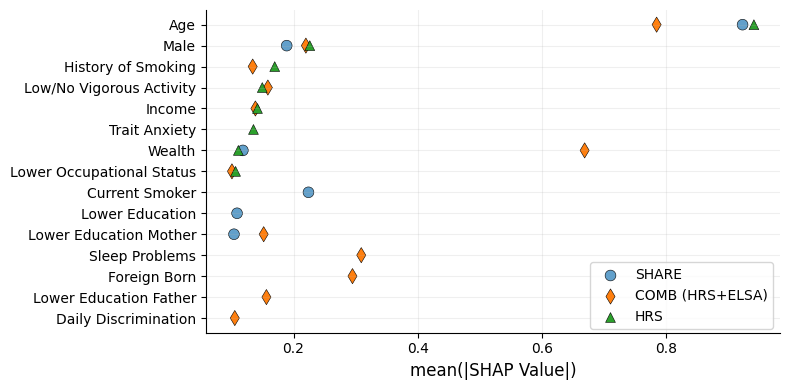

In [138]:
import matplotlib.pyplot as plt
fontsize_ticks = 12
fontsize_labels = 12
linewidth=0.4
var_dict = model_params['var_dict']
df_shap_plot= df_shaps[['var','HRS',f'COMB_{comb_type}','SHARE']].copy()
df_shap_plot.dropna(thresh=2,inplace=True)
df_shap_plot.sort_values(by=['HRS'],ascending=[False],inplace=True)

fig,ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
ax.scatter(df_shap_plot['SHARE'], df_shap_plot['var'], label='SHARE',color=colors['blue'],marker='o',s=[60]*len(df_shap_plot['var']),edgecolors='black',linewidth=linewidth)
ax.scatter(df_shap_plot[f'COMB_{comb_type}'], df_shap_plot['var'], label='COMB (HRS+ELSA)',color=colors['orange'],marker='d',s=[60]*len(df_shap_plot['var']),edgecolors='black',linewidth=linewidth)
ax.scatter(df_shap_plot['HRS'], df_shap_plot['var'], label='HRS',color=colors['green'],marker='^',s=[50]*len(df_shap_plot['var']),edgecolors='black',linewidth=linewidth)

#for var in df_shaps['var']:
#    ax.axhline(var, alpha=0.2, color='black')
    
ax.grid(axis='both',alpha=0.2)
ylabels = [var_dict[y_tick.get_text()] for y_tick in ax.get_yticklabels()]
ax.set_yticklabels(ylabels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('mean(|SHAP Value|)', fontsize=fontsize_labels)

ax.legend(bbox_to_anchor=(1, 0.24))
plt.gca().invert_yaxis()
fig.tight_layout()
del df_shap_plot
# plt.savefig(Path.cwd() / f'graphs/model_outputs/shap_overall_ranks.pdf')

## SHAP Ranks by age groups 

now we have four df including df_shap_all_COMB, df_shap_all_SHARE,df_shap_all_HRS and df_shap_all_ELSA that store the information of original data + the corresponding shaps, both on train and test dataset

In [17]:
# Define bins and labels
bins = [50, 54, 59, 64, 69, 74, 79, 84, 89, float('inf')]
labels = ['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']

# Function to categorize age
def categorize_age(df):
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)
    return df

# Apply function to each dataframe
df_shap_all_COMB = categorize_age(df_shap_all_COMB)
df_shap_all_SHARE = categorize_age(df_shap_all_SHARE)
df_shap_all_HRS = categorize_age(df_shap_all_HRS)
df_shap_all_ELSA = categorize_age(df_shap_all_ELSA)

plot HRS,SHARE and COMB into the same plot 

first rows: common factors 
second rows of plot: by different datasets (their own risk factors) 

common risk factors 

In [34]:
# merge the data 
temp_HRS = df_shap_all_HRS.groupby('age_group').mean(numeric_only=True)
temp_HRS.columns = [x+'_HRS' if x!='age_group' else x for x in temp_HRS.columns]

temp_SHARE = df_shap_all_SHARE.groupby('age_group').mean(numeric_only=True)
temp_SHARE.columns = [x+'_SHARE' if x!='age_group' else x for x in temp_SHARE.columns]

temp = pd.merge(left=temp_HRS,left_on='age_group',right=temp_SHARE,right_on='age_group')

temp_COMB = df_shap_all_COMB.groupby('age_group').mean(numeric_only=True)
temp_COMB.columns = [x+'_COMB' if x!='age_group' else x for x in temp_COMB.columns]

temp = pd.merge(left=temp,left_on='age_group',right=temp_COMB,right_on='age_group')


In [60]:
[x for x in temp.columns if 'age' in x ]

['age_HRS',
 'age_shap_HRS',
 'age_SHARE',
 'age_shap_SHARE',
 'age_COMB',
 'age_shap_COMB']

In [ ]:
axs

In [78]:
df_shaps.rename(columns={"COMB_3":"COMB"},inplace=True)

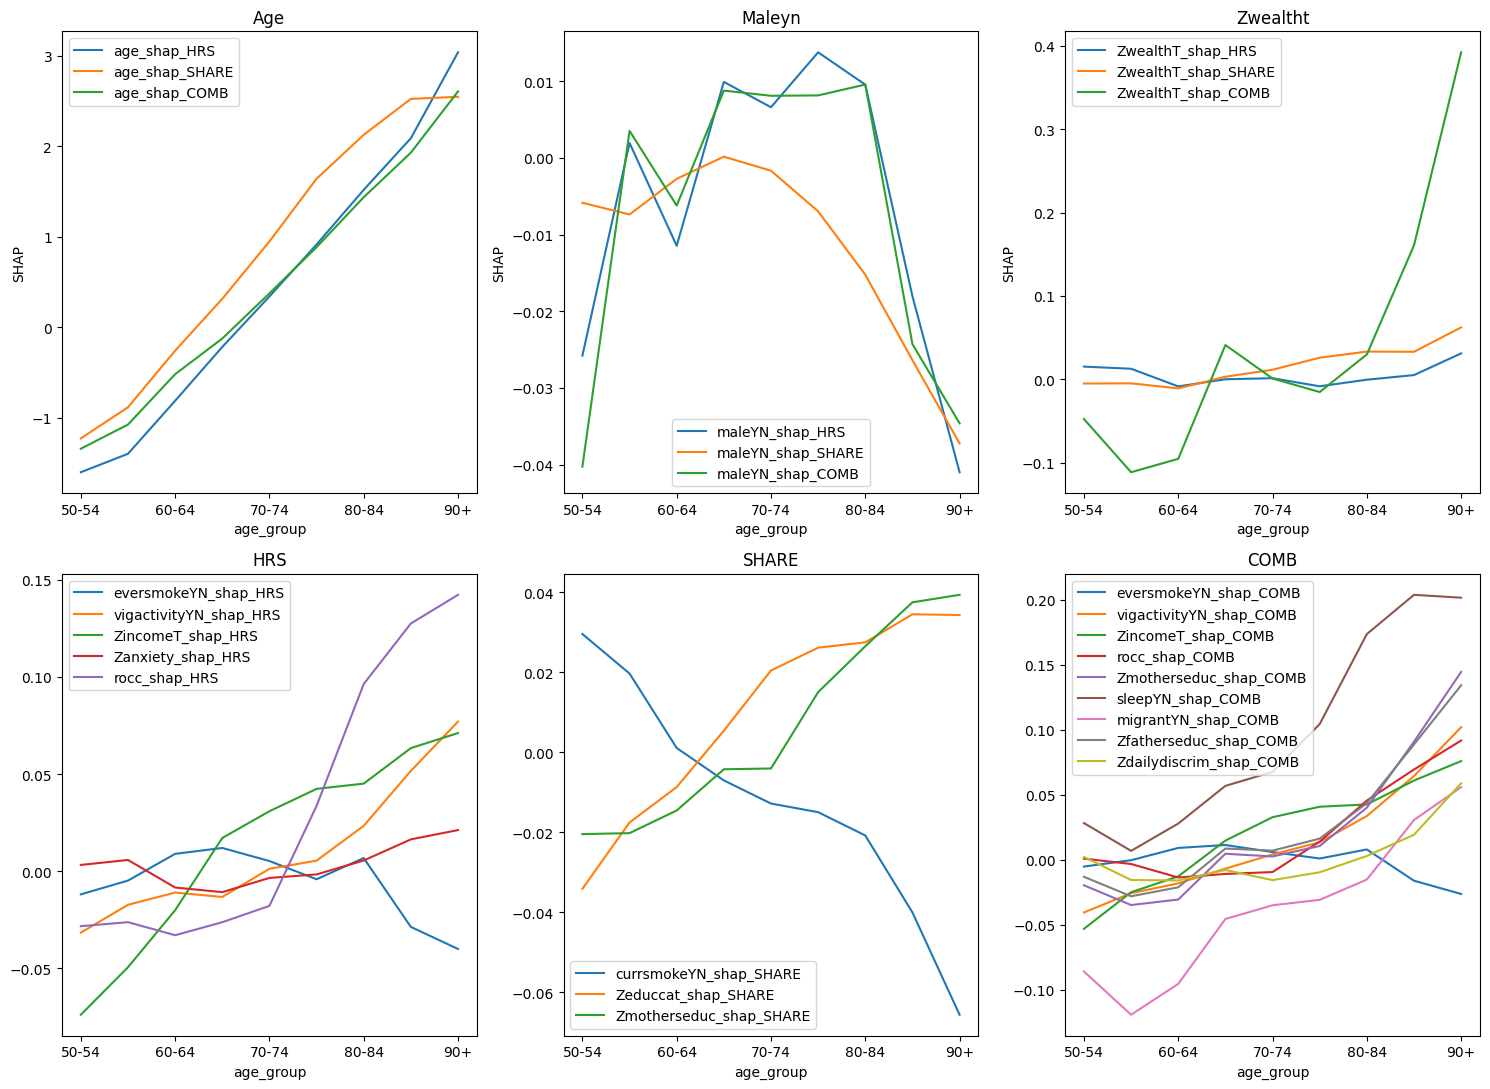

In [80]:
# vars in common = ['age','maleYN','ZwealthT']

from matplotlib import pyplot as plt 
cols_all = ['age_shap','maleYN_shap','ZwealthT_shap']
datasets = ['HRS','SHARE','COMB']
fig,axs = plt.subplots(2,3,figsize=(15, 11))

for j in range(0,2):
    for i in range(0,3):
        if j ==0:
            col = cols_all[i]
            cols = [f'{col}_{y}' for y in datasets]
            temp.plot(y=cols,ax=axs[j,i],title=col.replace("_shap",'').capitalize()).legend(loc='best')
            axs[j,i].set_ylabel('SHAP')
        else:
            dataset=datasets[i]
            
            y_cols = [f'{x}_shap_{dataset}' for x in df_shaps.loc[df_shaps[dataset].notnull(),'var']]#+['currsmokeYN_shap']
            for col in cols_all:
                y_cols.remove(f'{col}_{dataset}')
            temp.plot(y=y_cols,ax=axs[j,i],title=dataset).legend(loc='best')
            
fig.tight_layout()


In [38]:
cols = [x+y for x in ['age','maleYN','ZwealthT'] for y in ['_HRS','SHARE','COMB']]


['age_HRS',
 'ageSHARE',
 'ageCOMB',
 'maleYN_HRS',
 'maleYNSHARE',
 'maleYNCOMB',
 'ZwealthT_HRS',
 'ZwealthTSHARE',
 'ZwealthTCOMB']

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


<Axes: title={'center': 'HRS'}, xlabel='age_group'>

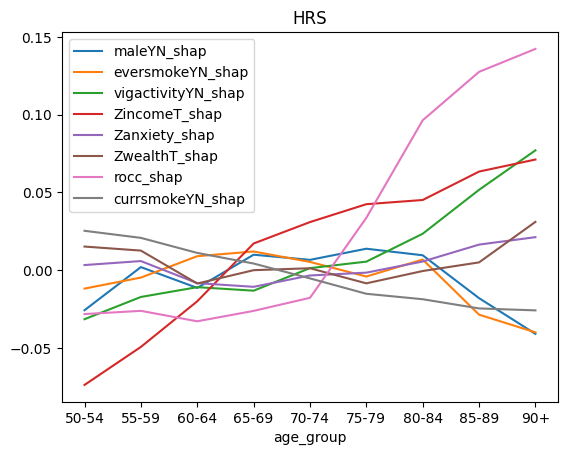

In [18]:


temp = df_shap_all_HRS.groupby('age_group').mean()
temp.reset_index(inplace=True)
y_cols = [f'{x}_shap' for x in df_shaps.loc[df_shaps['HRS'].notnull(),'var']]+['currsmokeYN_shap']
y_cols.remove('age_shap')
temp.plot(x='age_group',y=y_cols,title='HRS')

child_adverse
adult_SES
behavioral
adult_adverse
social_connection
psych


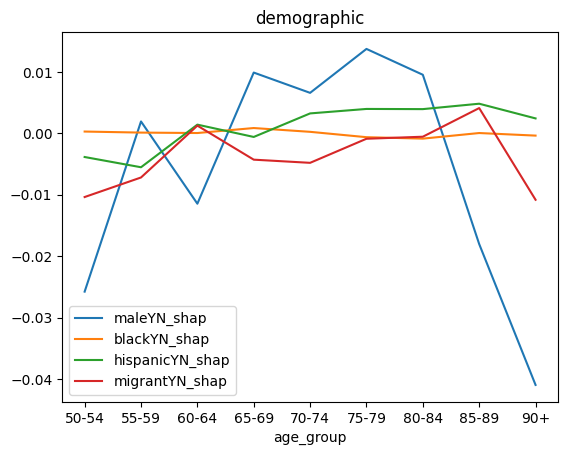

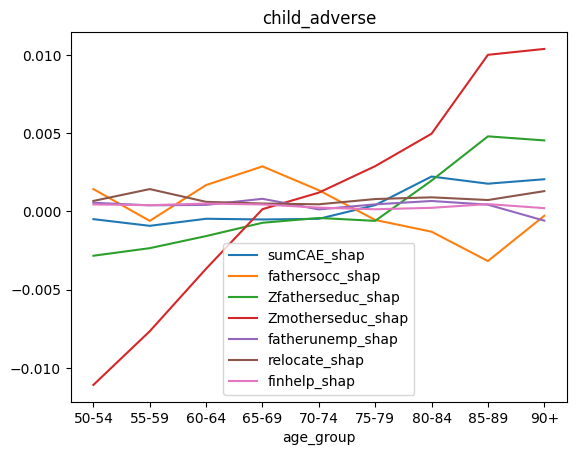

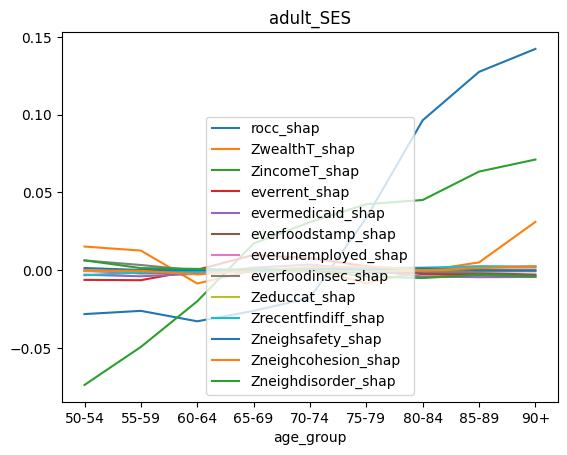

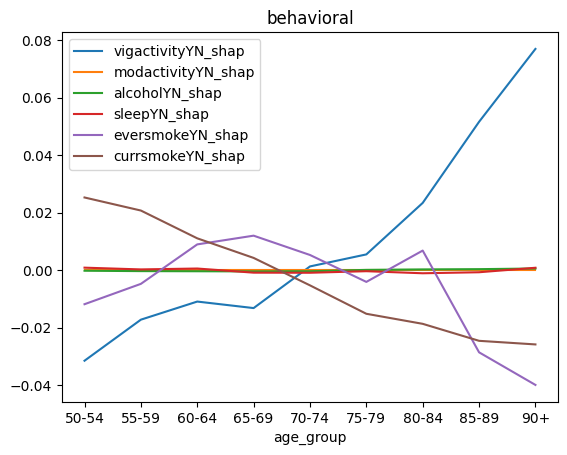

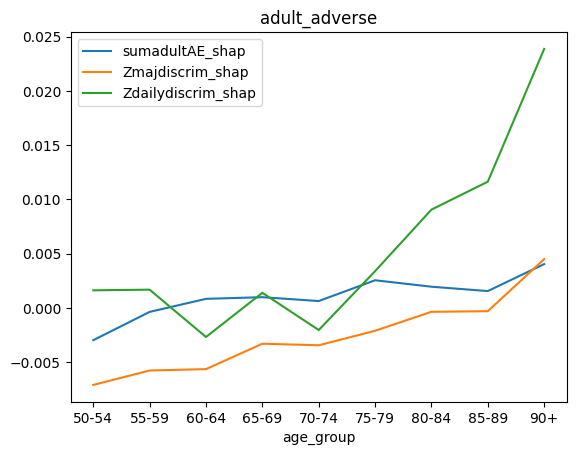

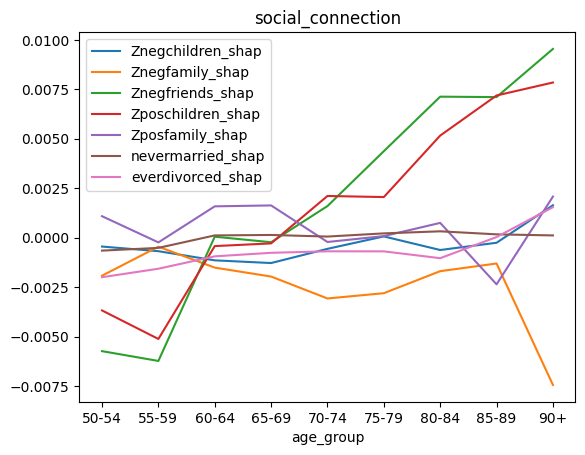

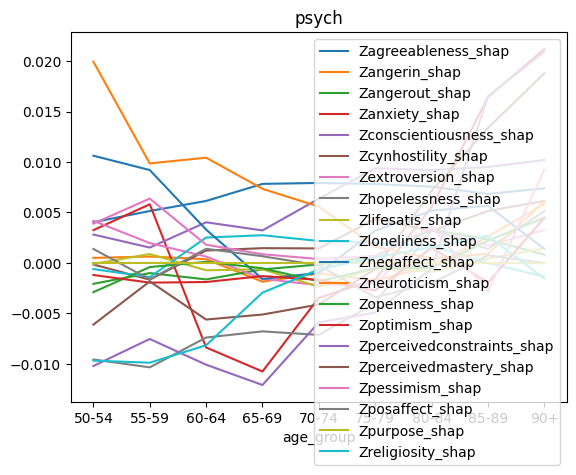

In [158]:
# by domain?
for domain in ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']:
    var_set = [f'{x}_shap' for x in params.domain_dict[domain] if x!='age']
    
    if domain!='demographic':
        print(domain)
        for var in params.domain_dict['demographic']:
            if f'{var}_shap' in var_set: 
                var_set.remove(f'{var}_shap')
    temp.plot(x='age_group',y=var_set,title=domain)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


<Axes: title={'center': 'SHARE'}, xlabel='age_group'>

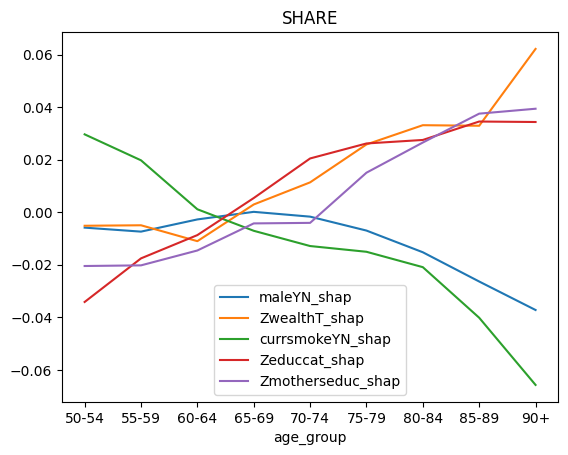

In [133]:
# SHARE
temp = df_shap_all_SHARE.groupby('age_group').mean()
temp.reset_index(inplace=True)
y_cols = [f'{x}_shap' for x in df_shaps.loc[df_shaps['SHARE'].notnull(),'var']]
y_cols.remove('age_shap')
temp.plot(x='age_group',y=y_cols,title='SHARE')

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


<Axes: title={'center': 'COMB'}, xlabel='age_group'>

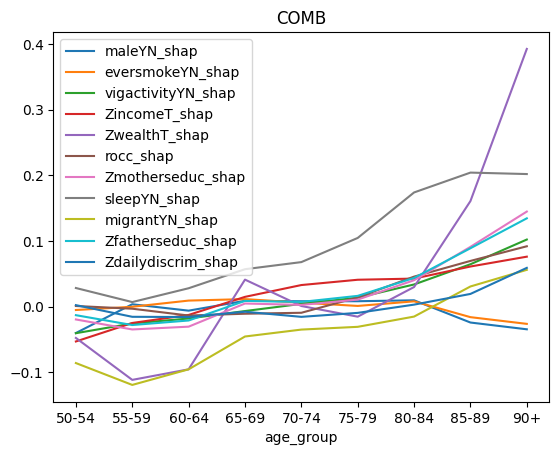

In [134]:
# df_shap_all_COMB
temp = df_shap_all_COMB.groupby('age_group').mean()
temp.reset_index(inplace=True)
y_cols = [f'{x}_shap' for x in df_shaps.loc[df_shaps['COMB_3'].notnull(),'var']]
y_cols.remove('age_shap')
temp.plot(x='age_group',y=y_cols,title='COMB')

# Results by gender, age and year 

In [196]:
df_results = pd.DataFrame(columns = ['dataset','train_test','pred','pred_prob','death_year','age','maleYN'])

## accuracy by age and year 

In [ ]:
# fit model
dataset= 'HRS'

df = params.data_reader(dataset='HRS',source='us',bio=False)
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain='all', model='lgb',
                                     train_subset_size=1, order=0)
print_model_fits(evas=metric(model))
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)


In [212]:
temp = pd.DataFrame()
# train 
dataset = 'HRS'
train_test = 'train'
ind = model.X_train.index
temp['pred'] = model.train_set_predict
temp['pred_prob'] = model.train_set_predict_prob
temp['train_test']=[train_test]*len(temp)
temp['dataset']=[dataset]*len(temp)
for col in ['death_year','age','maleYN']:  
    temp[col]= model.X_train[col]

df_results = temp


In [178]:
temp['Zneighdisorder']=model.X_train['Zneighdisorder']

In [179]:
temp['Zneighdisorderr']=df.loc[model.X_train.index,'Zneighdisorder']

# SuperLearner 

In [2]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner
import random 

#platform = "jupyter"
#params.confirm_cwd(platform)
model_params = params.model_params

# specification
model_params['k'] = 10
model_params['y_colname'] = 'death'

## HRS

In [ ]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
domain = 'all'

df_eva_10_seeds = pd.DataFrame()

for i in range(0,10):
    seed = random.randint(a=1,b=2**32 - 1)
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict'][domain],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
df_eva_10_seeds  

In [ ]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_HRS.csv',index=False)

## SHARE

In [9]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
df = df.loc[(df['deathY']>2005)|( df['death']==0),]


domain_name = 'share'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))


df_eva_10_seeds = pd.DataFrame()

for i in range(0,10):
    seed = random.randint(a=1,b=2**32 - 1)
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict'][domain_name],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
  

15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


15034 15034
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


In [10]:
df_eva_10_seeds.loc[df_eva_10_seeds['model']=='XGB']

model    pr_auc   roc_auc        f1     efron       ffc        ip       imv  \
0   XGB  0.452626  0.774512  0.404725  0.139403  0.430002  0.198750  0.042754   
0   XGB  0.484880  0.781372  0.420326  0.158311  0.407198  0.194359  0.055111   
0   XGB  0.449228  0.768069  0.404277  0.131136  0.415600  0.197685  0.041996   
0   XGB  0.497378  0.794411  0.435533  0.182753  0.441970  0.196621  0.061906   
0   XGB  0.467937  0.773300  0.422299  0.146370  0.397718  0.194226  0.048540   
0   XGB  0.488450  0.783378  0.416961  0.163960  0.418012  0.195224  0.054504   
0   XGB  0.475717  0.776716  0.413121  0.151642  0.421807  0.196754  0.047736   
0   XGB  0.473878  0.776649  0.413897  0.156098  0.413604  0.195357  0.050496   
0   XGB  0.464752  0.775540  0.407143  0.148031  0.415012  0.196222  0.048868   
0   XGB  0.491636  0.782845  0.432725  0.164027  0.417004  0.195091  0.055724   

         seed  
0   302274650  
0  3751003698  
0   734681386  
0  2508086116  
0  4094664879  
0   741098468  
0  2525745226  
0   515638503  
0  1796948398  
0  1194075443

In [11]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_SHARE.csv',index=False)

## ELSA

In [34]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)

domain = 'ELSA'
model_params['domain_dict'][domain]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

df_eva_10_seeds = pd.DataFrame()

for i in range(0,10):
    seed = random.randint(a=1,b=2**32 - 1)
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict'][domain],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
df_eva_10_seeds  

5412 5412
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


5412 5412
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


5412 5412
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


5412 5412
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


5412 5412
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


5412 5412
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


5412 5412
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


5412 5412
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


model    pr_auc   roc_auc        f1     efron       ffc        ip  \
0            XGB  0.261698  0.904377  0.180556  0.084001  0.213275  0.056911   
1            LGB  0.245781  0.908983  0.157143  0.080005  0.209844  0.056911   
2            SGD  0.267366  0.899634  0.207792 -0.163759  0.000482  0.056911   
3   DecisionTree  0.271828  0.615453  0.253165 -0.703907 -0.463435  0.056911   
4       AdaBoost  0.251872  0.911819  0.078740 -2.319116 -1.850690  0.056911   
..           ...       ...       ...       ...       ...       ...       ...   
8     KNeighbors  0.171022  0.745821  0.097902 -0.046604  0.101103  0.056911   
9        Bagging  0.252082  0.843902  0.108527  0.064487  0.196516  0.056911   
10  RandomForest  0.192637  0.815651  0.082645  0.038496  0.174192  0.056911   
11    ExtraTrees  0.157486  0.756136  0.034783 -0.005209  0.136656  0.056911   
12            sl  0.262051  0.904448  0.000000  0.094445  0.222246  0.056911   

         imv          seed  
0   0.011160  534430929791  
1   0.014890  534430929791  
2  -0.475172  534430929791  
3  -0.475172  534430929791  
4  -0.144483  534430929791  
..       ...           ...  
8  -0.475172  751979614223  
9  -0.475172  751979614223  
10 -0.475172  751979614223  
11 -0.475172  751979614223  
12  0.014548  751979614223  

[104 rows x 9 columns]

In [35]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_ELSA.csv',index=False)

In [49]:
df_eva_10_seeds.loc[df_eva_10_seeds['model']=='sl']

model    pr_auc   roc_auc   f1     efron       ffc        ip       imv  \
12    sl  0.255106  0.905240  0.0  0.100181  0.227172  0.056911  0.015265   
12    sl  0.293335  0.914493  0.0  0.128802  0.251754  0.056911  0.017631   
12    sl  0.232898  0.909485  0.0  0.073796  0.204511  0.056911  0.016087   
12    sl  0.264542  0.906120  0.0  0.077065  0.207319  0.056911  0.015378   
12    sl  0.249832  0.907506  0.0  0.086886  0.215753  0.056911  0.015772   
12    sl  0.281738  0.910751  0.0  0.119629  0.243875  0.056911  0.016482   
12    sl  0.260341  0.906439  0.0  0.087358  0.216159  0.056911  0.015609   
12    sl  0.262051  0.904448  0.0  0.094445  0.222246  0.056911  0.014548   

            seed  
12  534430929791  
12  620591933638  
12  290908585527  
12  904000071647  
12   33667513122  
12  988952497827  
12  734976885092  
12  751979614223

## Combed data 

In [3]:
comb_type = 1
domain_name = 'combination_all'
df,domain_lst = params.read_merged_data(type=1)
model_params['domain_dict'][domain_name]=domain_lst
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=comb_type)

model_params['var_dict']['dataset']='Datasource'


df_eva_10_seeds = pd.DataFrame()

for i in range(1,10):
    seed = random.randint(a=1,b=2**32 - 1)
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict'][domain_name],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_COMB_1.csv',index=False)
df_eva_10_seeds  

29944 29944
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


29944 29944
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


29944 29944
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


29944 29944
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


29944 29944
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


29944 29944
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


29944 29944
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


29944 29944
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


29944 29944
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract


model    pr_auc   roc_auc        f1     efron       ffc        ip  \
0            XGB  0.550011  0.824134  0.476812  0.235541  0.492182  0.205450   
1            LGB  0.571839  0.833947  0.477885  0.259967  0.508408  0.205450   
2            SGD  0.512478  0.769095  0.502814 -0.267552  0.157985  0.205450   
3   DecisionTree  0.478041  0.641338  0.422519 -0.492494  0.008560  0.205450   
4       AdaBoost  0.552697  0.825225  0.474070 -0.522160 -0.011148  0.205450   
..           ...       ...       ...       ...       ...       ...       ...   
8     KNeighbors  0.505436  0.761296  0.469071  0.126665  0.392240  0.202044   
9        Bagging  0.488838  0.774564  0.426253  0.133665  0.397112  0.202044   
10  RandomForest  0.499789  0.781683  0.408587  0.152404  0.410152  0.202044   
11    ExtraTrees  0.469294  0.762215  0.397700  0.107637  0.378998  0.202044   
12            sl  0.566170  0.832600  0.420697  0.254594  0.481267  0.202044   

         imv        seed  
0   0.086454  4242701116  
1   0.093823  4242701116  
2  -0.377405  4242701116  
3  -0.377405  4242701116  
4  -0.256548  4242701116  
..       ...         ...  
8  -0.371301  3368915216  
9  -0.371301  3368915216  
10 -0.371301  3368915216  
11 -0.371301  3368915216  
12  0.097124  3368915216  

[117 rows x 9 columns]

In [10]:
for comb_type in [2,3,4]:
    domain_name = 'combination_all'
    df,domain_lst = params.read_merged_data(type=comb_type)
    model_params['domain_dict'][domain_name]=domain_lst
    df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=comb_type)
    #model_params['domain_dict'][domain_name].remove('hhid')
    #model_params['domain_dict'][domain_name].remove('pn')
    model_params['var_dict']['dataset']='Datasource'


    df_eva_10_seeds = pd.DataFrame()

    for i in range(0, 10):
        print(i)
        seed = random.randint(a=1,b=2**32 - 1)
        model_params['seed']=seed 
        superlearner = SuperLearner.superlearner(data=df,
                                test_size=model_params['test_size'],
                                domain_list=model_params['domain_dict'][domain_name],
                                y_colname=model_params['y_colname'],
                                k=model_params['k'],
                                random_state=seed,
                                train_subset_size=1)
        df_eva=sl_eva(superlearner)
        df_eva['seed']=[seed]*len(df_eva)
        df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
    df_eva_10_seeds.to_csv(Path.cwd()/f'results/sl_10seeds_COMB_{comb_type}.csv',index=False)
    df_eva_10_seeds  

0
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
1
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
2
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
3
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
4
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
7
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
8
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
9
24537 24537
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
0
14910 14910
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
1
14910 14910
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fo

In [52]:
df_eva_10_seeds.loc[df_eva_10_seeds['model']=='sl']

model    pr_auc   roc_auc        f1     efron       ffc        ip  \
12    sl  0.588215  0.805038  0.483116  0.237185  0.496487  0.237476   
12    sl  0.592102  0.806531  0.477364  0.240546  0.498705  0.237476   
12    sl  0.589063  0.806862  0.485742  0.239995  0.498341  0.237476   
12    sl  0.590275  0.806035  0.503327  0.239592  0.498075  0.237476   
12    sl  0.593237  0.804990  0.459888  0.238903  0.497620  0.237476   
12    sl  0.591541  0.806770  0.485903  0.241024  0.499020  0.237476   
12    sl  0.589103  0.804861  0.449351  0.238998  0.497683  0.237476   
12    sl  0.592222  0.806479  0.476694  0.240125  0.498427  0.237476   

         imv          seed  
12  0.112943  376153847797  
12  0.114138  787418247219  
12  0.113832   31740411401  
12  0.113467  317190349949  
12  0.113031  321417980035  
12  0.113740  145089720681  
12  0.112862   97370012488  
12  0.113835  304361721852

## Table 2

In [11]:
import warnings 
warnings.simplefilter("ignore") 
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'All Three Datasets','COMB_2':'HRS + SHARE','COMB_3':'HRS + ELSA','COMB_4':'SHARE + ELSA'}


In [12]:
df_table_1 = pd.DataFrame()
for dataset in ['HRS','SHARE','ELSA','COMB_1','COMB_2','COMB_3','COMB_4']:
    df_eva_10_seeds = pd.read_csv(Path.cwd()/f'results/sl_10seeds_{dataset}.csv')
    for model in ['sl','LGB','LogisticRegression']:
        temp = pd.DataFrame(df_eva_10_seeds.loc[df_eva_10_seeds['model']==model].mean()).T
        temp.loc[len(temp)-1,['model','dataset']]=[model,dataset]
        df_table_1=pd.concat([df_table_1,temp],axis=0)

In [13]:
# table 2, latex format 

for datasets in [['HRS','SHARE','ELSA'],['COMB_2','COMB_3','COMB_4'],['COMB_1']]: 
    if len(datasets)!=1:
        print(table_name_dict[datasets[0]],table_name_dict[datasets[1]],table_name_dict[datasets[2]])
    

        for eva in ['imv','roc_auc','pr_auc','efron','ffc','ip']:

            print()
            print("{}   & {:.3f} &  {:.3f} &  {:.3f} & {:.3f} &  {:.3f} &  {:.3f} & {:.3f} &  {:.3f}&  {:.3f} \\\\".format(eva.upper().replace('_',' '),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3),

                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[1])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[1])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[1])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3),

                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[2])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[2])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[2])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3)))

            print()
    else:
        print(table_name_dict[datasets[0]])
        for eva in ['imv','roc_auc','pr_auc','efron','ffc','ip']:
            print("{}   & \multicolumn{{3}}{{c}}{{{:.3f}}} &  \multicolumn{{3}}{{c}}{{{:.3f}}} & \multicolumn{{3}}{{c}}{{{:.3f}}} \\\\".format(eva.upper().replace('_',' '),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3)))
            print()       
              

HRS SHARE ELSA

IMV   & 0.200 &  0.204 &  0.211 & 0.069 &  0.072 &  -0.024 & 0.016 &  0.015&  0.018 \\


ROC AUC   & 0.822 &  0.825 &  0.831 & 0.795 &  0.800 &  0.448 & 0.908 &  0.909&  0.894 \\


PR AUC   & 0.689 &  0.687 &  0.707 & 0.497 &  0.507 &  0.161 & 0.262 &  0.246&  0.259 \\


EFRON   & 0.288 &  0.290 &  0.307 & 0.196 &  0.204 &  -0.050 & 0.096 &  0.080&  0.133 \\


FFC   & 0.562 &  0.564 &  0.574 & 0.446 &  0.452 &  0.277 & 0.224 &  0.210&  0.255 \\


IP   & 0.293 &  0.293 &  0.293 & 0.196 &  0.196 &  0.196 & 0.057 &  0.057&  0.057 \\

HRS + SHARE HRS + ELSA SHARE + ELSA

IMV   & 0.106 &  0.108 &  0.108 & 0.120 &  0.122 &  0.116 & 0.065 &  0.067&  0.062 \\


ROC AUC   & 0.808 &  0.810 &  0.810 & 0.860 &  0.862 &  0.852 & 0.833 &  0.837&  0.825 \\


PR AUC   & 0.580 &  0.585 &  0.585 & 0.624 &  0.625 &  0.629 & 0.481 &  0.497&  0.485 \\


EFRON   & 0.238 &  0.241 &  0.242 & 0.304 &  0.307 &  0.306 & 0.217 &  0.228&  0.219 \\


FFC   & 0.511 &  0.513 &  0.513 & 0.528 &  0.530 

## Combination

In [2]:
domain_name = 'combination_all'
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=1)
model_params['var_dict']['dataset']='Datasource'

In [ ]:

df_eva_10_seeds = pd.DataFrame()
for i in range(1,9):
    seed = random.randint(a=1,b=1000000000000)
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict']['combination_all'],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=model_params['random_state'],
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
    

In [13]:
df_eva_10_seeds

model    pr_auc   roc_auc        f1     efron       ffc        ip  \
0            XGB  0.674514  0.863575  0.572674  0.342862  0.562336  0.224643   
1            LGB  0.630034  0.840904  0.522448  0.292666  0.528905  0.224643   
2            SGD  0.532138  0.768993  0.527175 -0.171521  0.219749  0.224643   
3   DecisionTree  0.739439  0.812944  0.707196  0.230866  0.487745  0.224643   
4       AdaBoost  0.581372  0.816307  0.480286 -0.381784  0.079710  0.224643   
..           ...       ...       ...       ...       ...       ...       ...   
8     KNeighbors  0.594081  0.812407  0.523251  0.226532  0.484858  0.224643   
9        Bagging  0.810744  0.913088  0.715294  0.502274  0.668506  0.224643   
10  RandomForest  0.800814  0.910525  0.699271  0.487248  0.658499  0.224643   
11    ExtraTrees  0.845327  0.923936  0.739791  0.548662  0.699401  0.224643   
12            sl  0.884445  0.948398  0.740985  0.615104  0.743653  0.224643   

         imv          seed  
0   0.139033  581958458618  
1   0.122198  581958458618  
2  -0.352873  581958458618  
3  -0.352873  581958458618  
4  -0.242582  581958458618  
..       ...           ...  
8  -0.352873  206243973551  
9  -0.352873  206243973551  
10 -0.352873  206243973551  
11 -0.352873  206243973551  
12  0.218027  206243973551  

[104 rows x 9 columns]

In [12]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds.csv',index=False)

In [15]:
for seed in df_eva_10_seeds['seed'].unique():
    df_eva_10_seeds.loc[(df_eva_10_seeds['seed']==seed)]

# Domain Contribution

In [22]:
from src.Domains_Diff_in_combination import get_dc_params,dc_iteration,dd_post_process,dc_plot
model_params = params.model_params

## HRS

In [45]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
domain_name = 'HRS'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)

pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


FixedFormatter should only be used together with FixedLocator


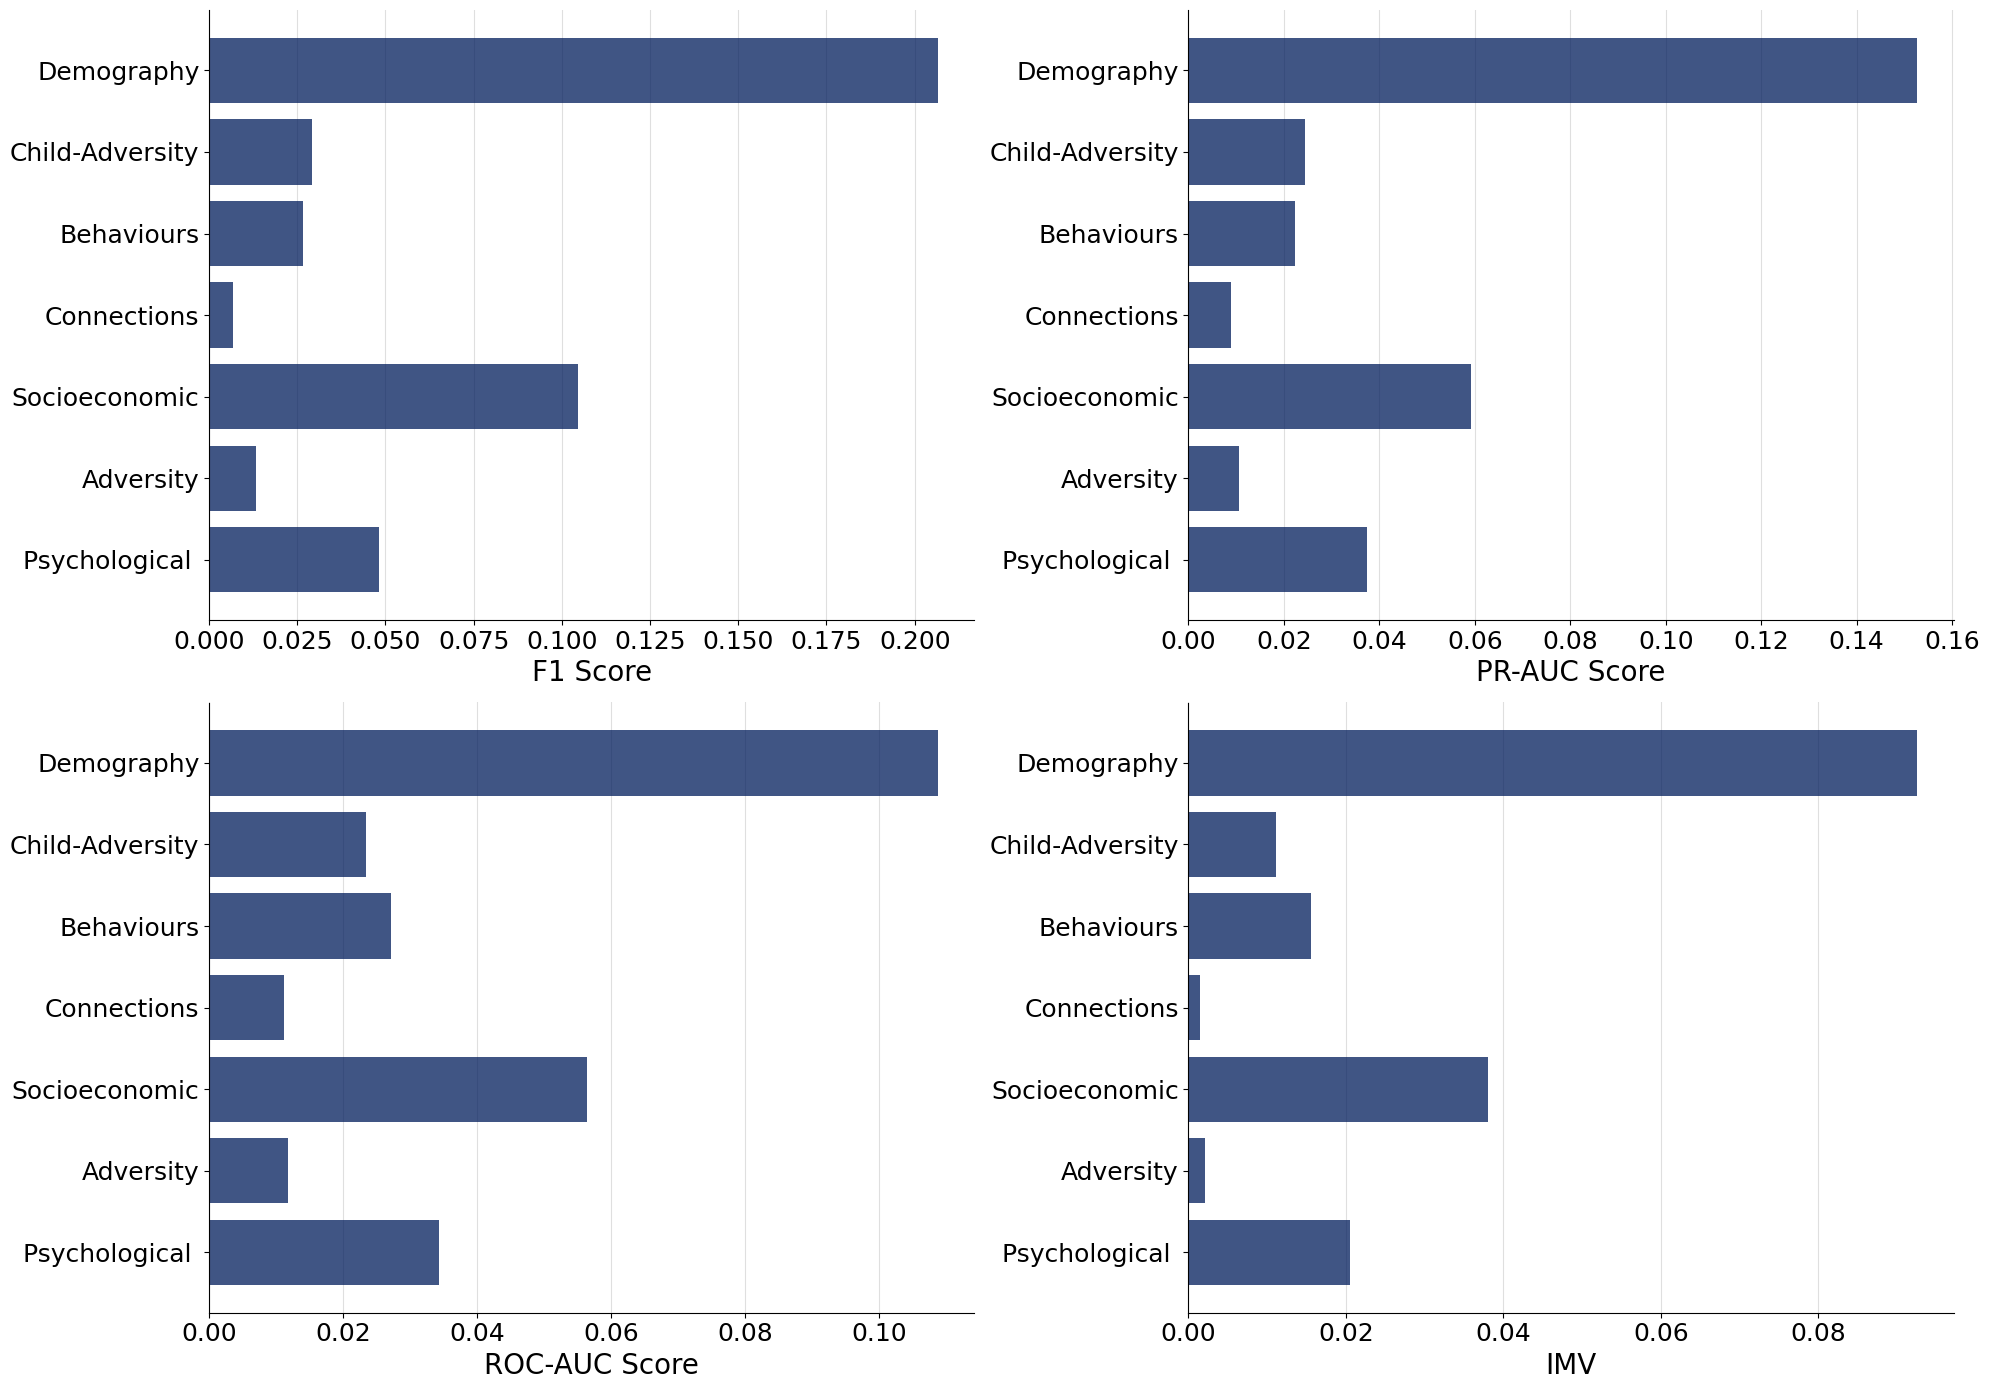

In [23]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
domain_name = 'HRS'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)


df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_hrs,contribution_hrs = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_hrs,save_control=False)
del df

## SHARE


there are 7 domains and 127 iterations
pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


FixedFormatter should only be used together with FixedLocator


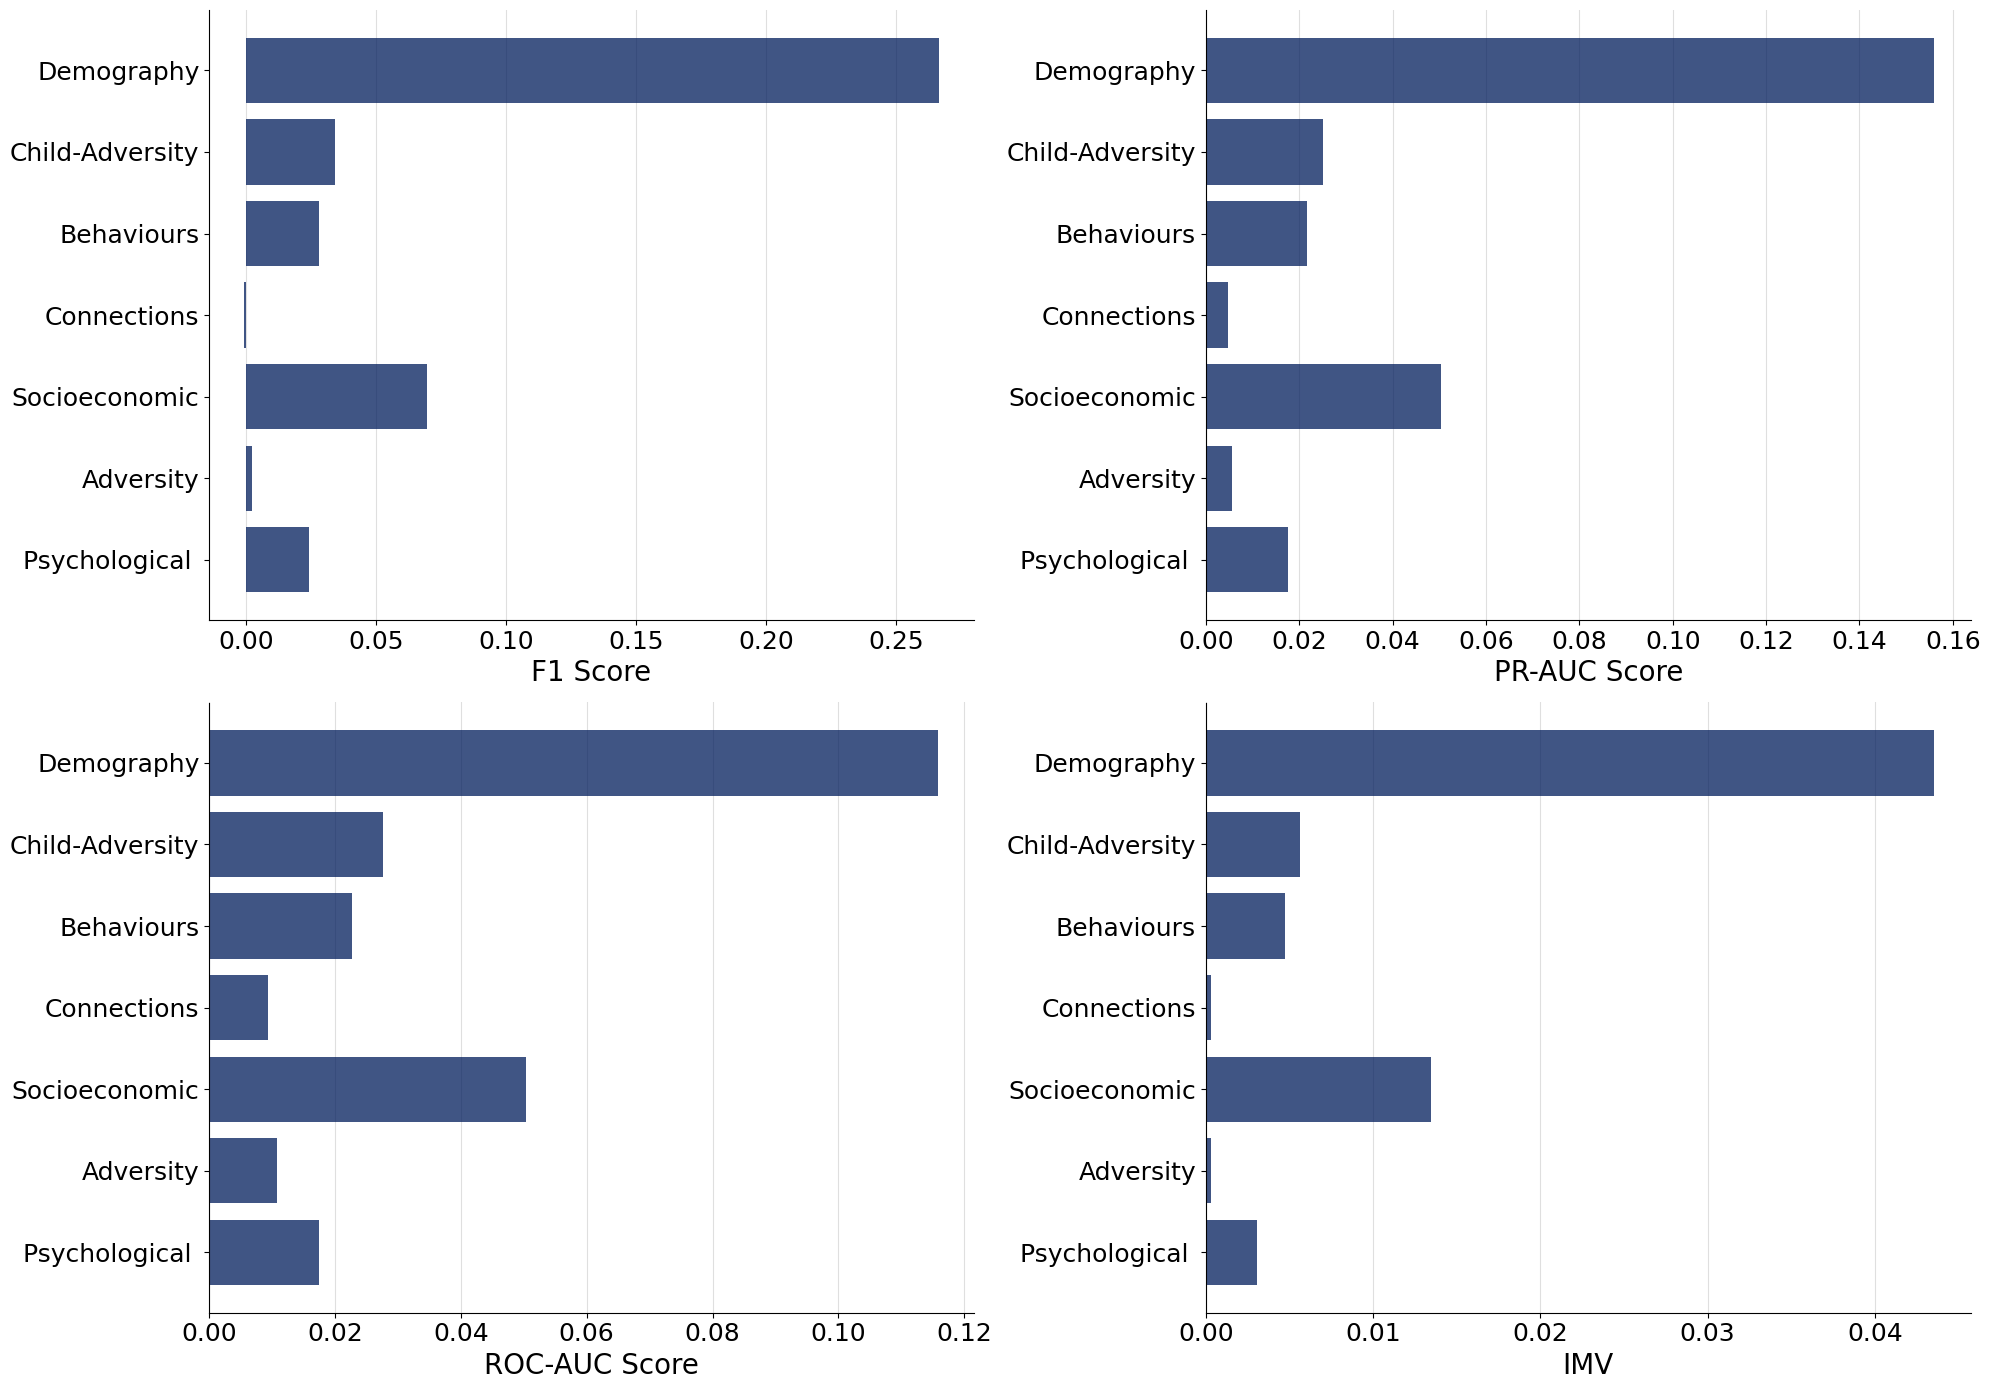

In [24]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
domain_name = 'share'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict']['share']:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)
print(f'there are {len(domain_name_lst)} domains and {len(iterations)} iterations')
df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_share,contribution_share = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_share,save_control=False)
del df 

## ELSA

In [25]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'ELSA'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))


there are 7 domains and 127 iterations
pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


FixedFormatter should only be used together with FixedLocator


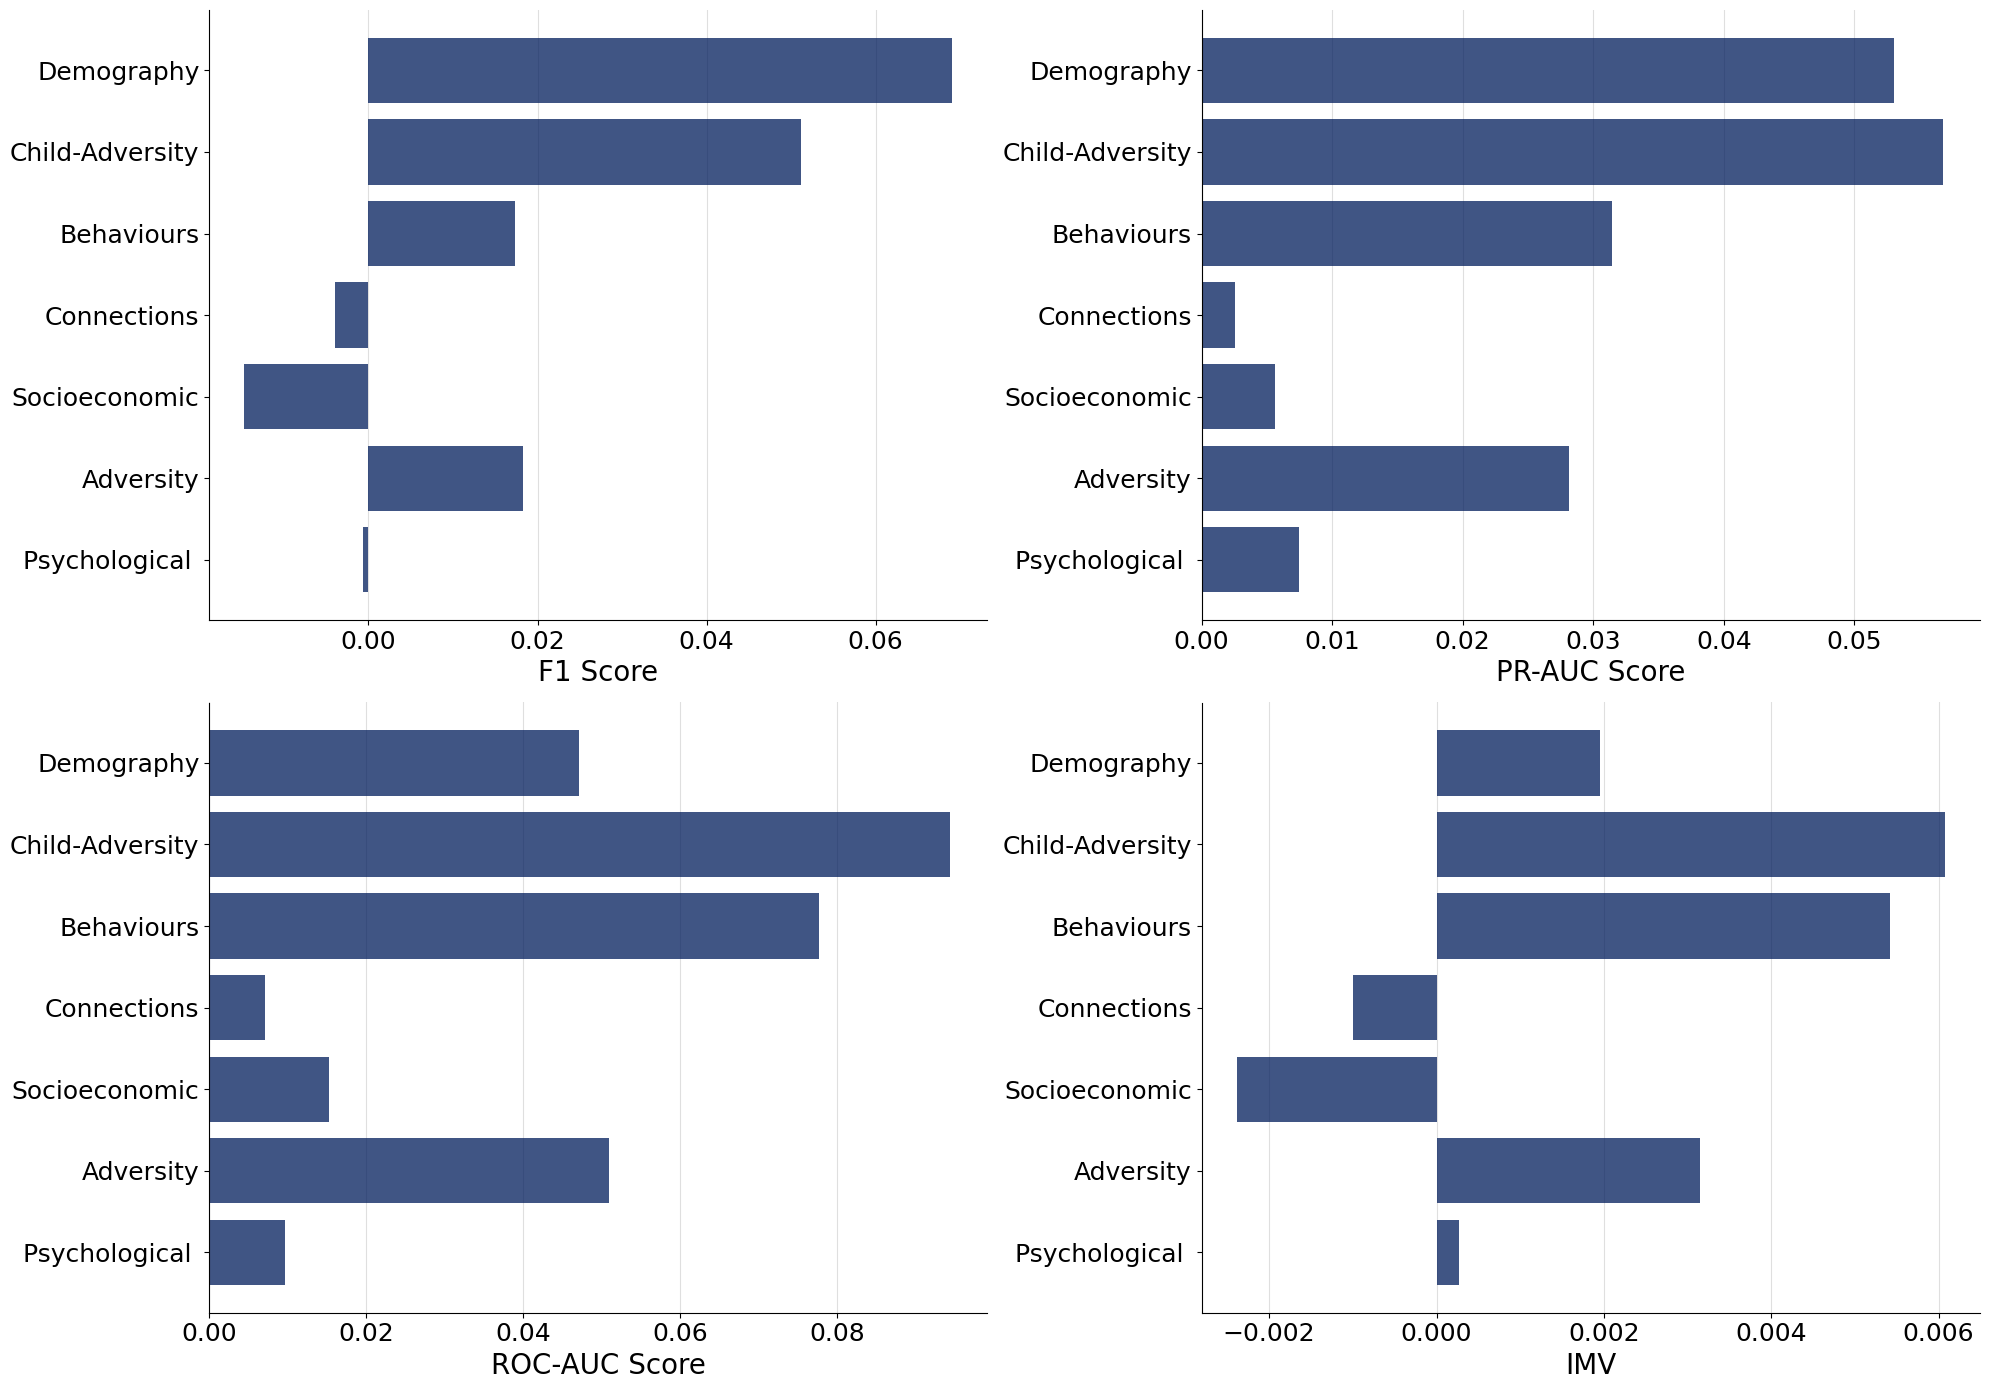

In [26]:
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)
print(f'there are {len(domain_name_lst)} domains and {len(iterations)} iterations')

df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_elsa,contribution_elsa = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_elsa,save_control=False)
del df 

## Combination

In [27]:
comb_type = 3
domain_name = 'combination_all'
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type = comb_type)
model_params['var_dict']['dataset']='Datasource'


In [28]:
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)
print(f'there are {len(domain_name_lst)} domains and {len(iterations)} iterations')

there are 7 domains and 127 iterations


pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


FixedFormatter should only be used together with FixedLocator


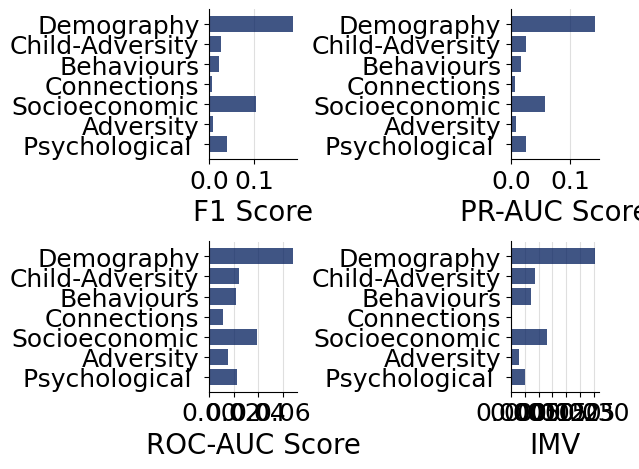

In [20]:
df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_comb,contribution_comb = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_comb,save_control=False)

In [29]:
contribution_comb['dataset']='comb'
contribution_hrs['dataset']='hrs'
contribution_share['dataset']='share'
contribution_elsa['dataset']='elsa'

contribution = pd.concat([contribution_comb,contribution_hrs,contribution_share,contribution_elsa],axis=0)
contribution.to_csv(Path.cwd()/'results/domain_contribution_all_lgb_20231224.csv')

## Figrue 2: Domain Contribution

In [30]:
contribution=pd.read_csv(Path.cwd()/'results/domain_contribution_all_lgb_20231224.csv',index_col=0)

[0.0074850486087988, 0.0025592792913836, 0.0567889191916268, 0.0056238461687833, 0.0314555848487105, 0.0530122998272893, 0.0281148834556274, 0.0074850486087988]


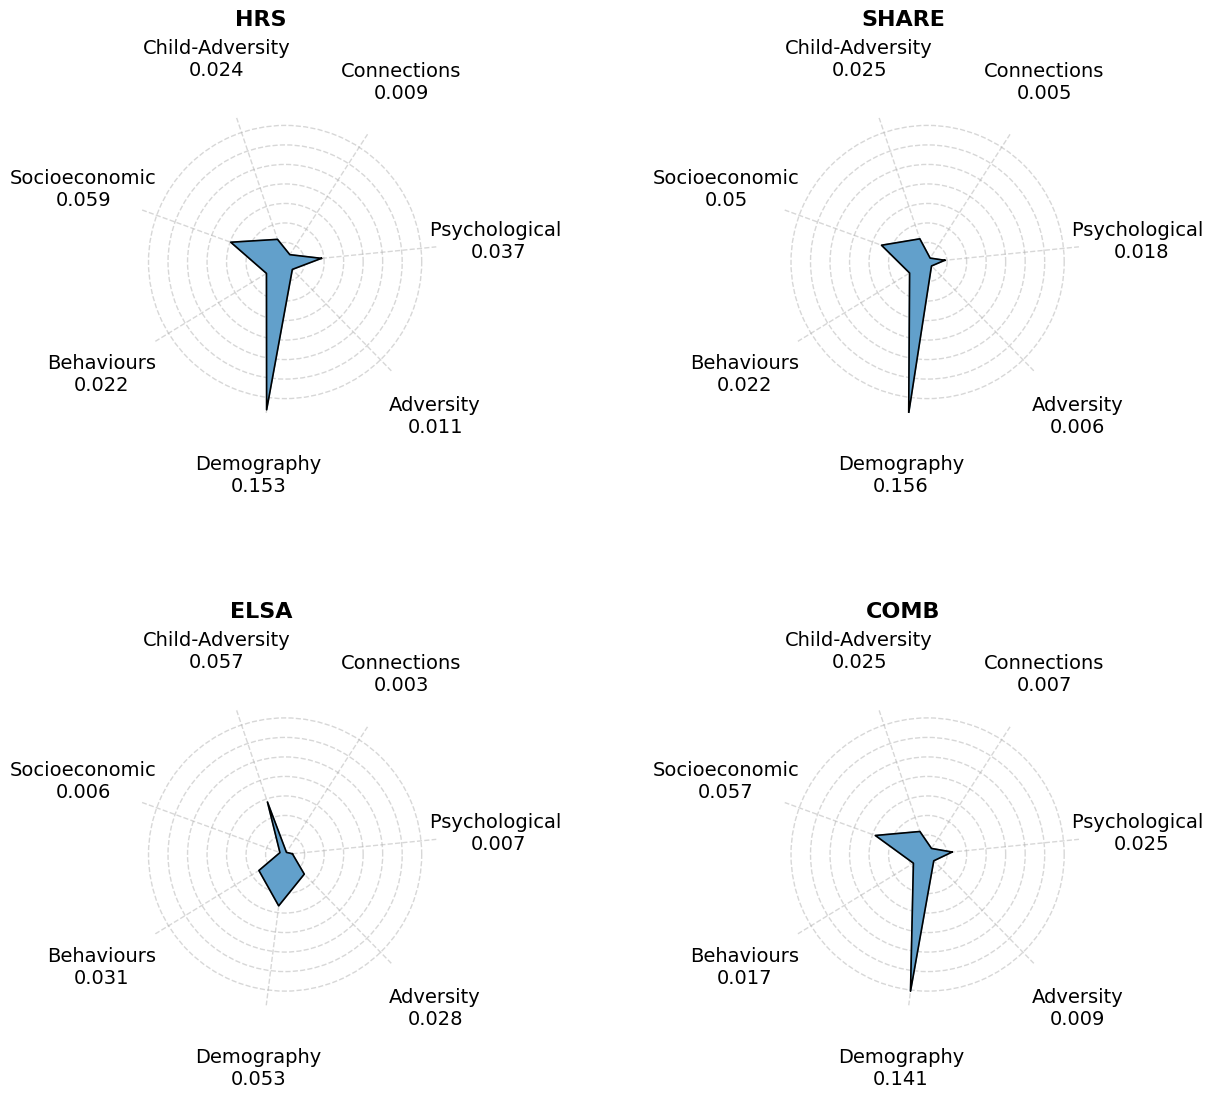

In [49]:
import matplotlib.pyplot as plt
import numpy as np

orders= {'adult_adverse': 6, 'adult_SES': 3, 'social_connection': 1, 'psych': 0, 'demographic': 5, 'behavioral': 4, 'child_adverse': 2}
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological ',
                      'bio_adjusted':'Biomarkers',
                       'pr_f1_contribution':'F1 Score',
                       'pr_auc_contribution':'PR-AUC Score',
                      'roc_auc_contribution':'ROC-AUC Score',
                      'imv_contribution':'IMV'}
figure = plt.figure()
fontsize_ticks = 14
fontsize_labels = 16
plt.rcParams["figure.figsize"] = [13,12]
figure.subplots_adjust(left=0.12, bottom=0.1,top=0.995,right=0.995)
datasets = ['hrs','share','elsa','comb']


for m in range(1,5):
    df = contribution.loc[contribution['dataset']==datasets[m-1]].copy()
    df['order']=[orders[x] for x in df['goal_domain']]

    df.sort_values(by=['order'],inplace=True)
    
    #df.drop(columns=['order'],inplace=True)
    
    eva_score = 'pr_auc'

   
    values = list(df[f'{eva_score}_contribution'])
    values += [values[0]]

    labels = [replace_name_dict[x] for x in df['goal_domain']]

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1] 
    angles = [x+0.1 for x in angles] # Close the heptagon

    axis = figure.add_subplot(int(f'22{m}'), polar=True)

    # Plot the heptagon shape
    if datasets[m-1]=='elsa':
        print(values)
    axis.plot(angles, values, color='black', linewidth=1.2, linestyle='solid')
    axis.fill(angles, values, color=colors['blue'])
    axis.set_ylim([0, max(contribution[f'{eva_score}_contribution'])])


    # Set the labels for each dimension
    axis.set_xticks(angles[:-1])
    axis.set_xticklabels([])
    


    axis.spines['polar'].set_visible(False)
    # ax.spines['polar'].set_alpha(0.1)

    # set title 
    axis.text(1.67,0.25,datasets[m-1].upper(), ha='center', va='center',fontsize=fontsize_labels,weight="bold")

    # Add the dimension labels
    for i, angle in enumerate(angles[:-1]):
        x = angle
        y = 0.220
        axis.text(x, y, f'{labels[i]}\n{round(values[i],3)}', ha='center', va='center',fontsize=fontsize_ticks)



        axis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5,which='major')
        axis.set_yticklabels([])

    
    # Set the aspect ratio to equal  
    axis.set_aspect('equal')
    axis.set_axisbelow(True)
figure.tight_layout()
# Show the plot
plt.savefig(Path.cwd() / 'graphs/model_outputs/domain_contribution_all.pdf')
# plt.show()

# Error Investigation 

 HRS as an example 

[22766,
 25612,
 28458,
 31304,
 34150,
 36996,
 39841,
 42687,
 45533,
 48379,
 51225,
 54071,
 56917]

In [38]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain='all', model='lgb', train_subset_size=1, order=0)

In [52]:
df_invs = pd.DataFrame()
df_invs['true'] =  model.y_test 
df_invs['pred'] =  model.test_set_predict
df_invs['pred_prob'] = model.test_set_predict_prob
df_invs['correct']=[1 if x==y else 0 for x,y in zip(df_error['true'],df_error['pred'])]
df_invs[x.columns] = model.X_test

among the 4073 records in the out-of-sample, 3163 are correct, 
910 incorrect ->
264 fp 
646 fn

In [57]:
df_error=df_invs.loc[df_invs['correct']==0]
df_correct=df_invs.loc[df_invs['correct']==1]

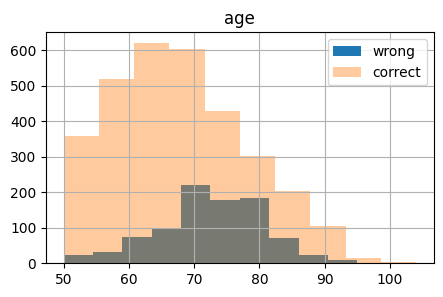

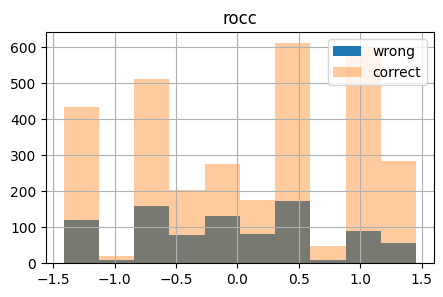

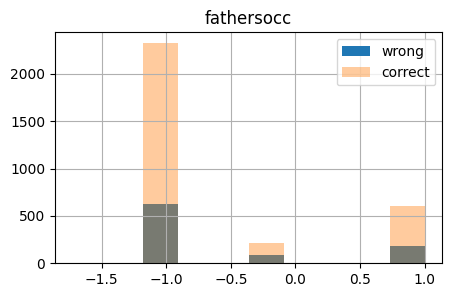

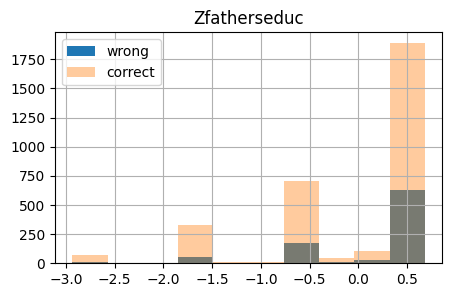

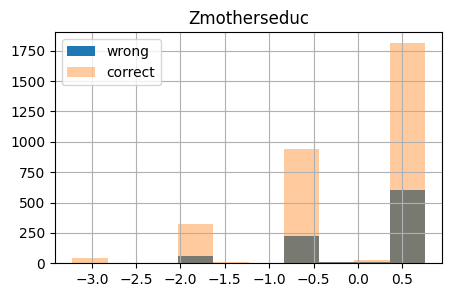

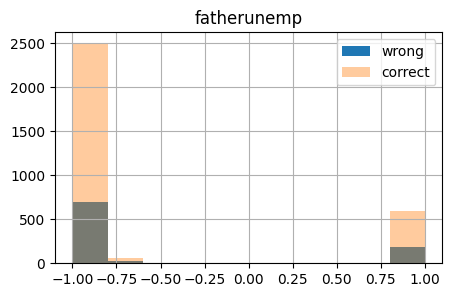

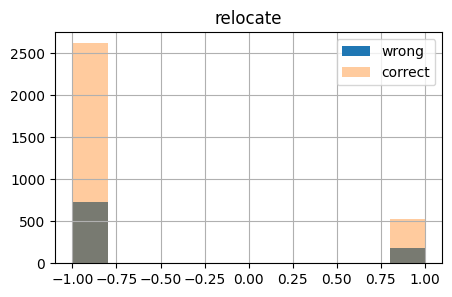

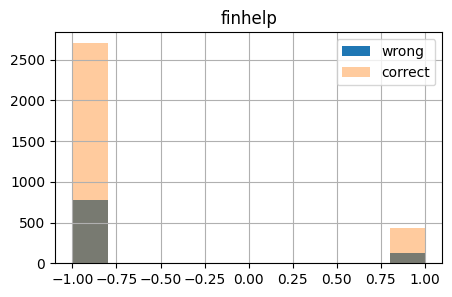

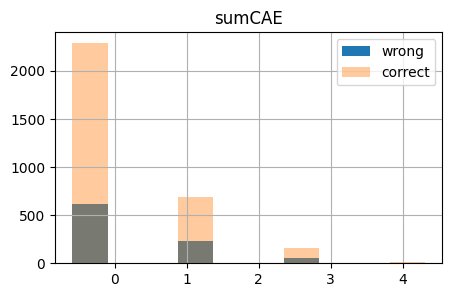

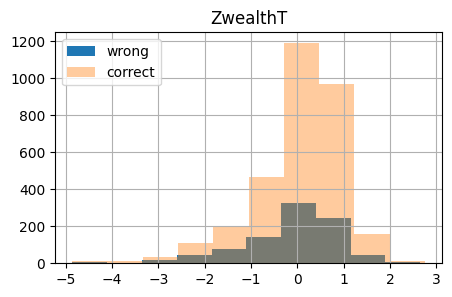

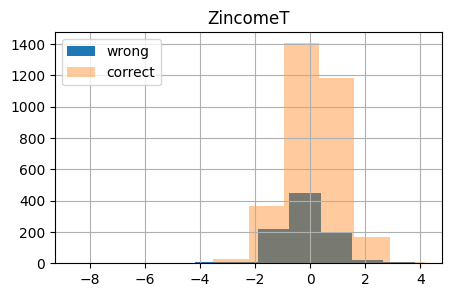

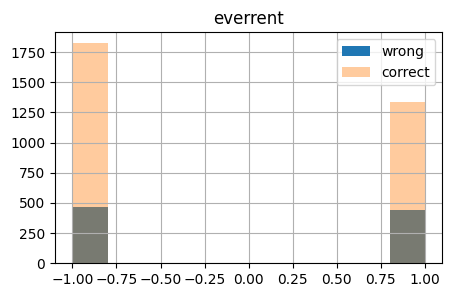

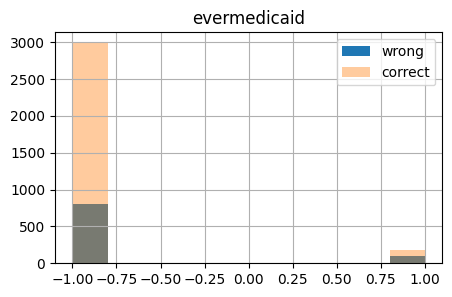

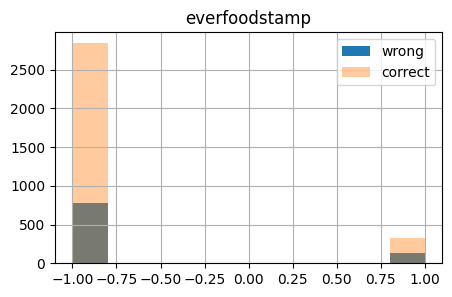

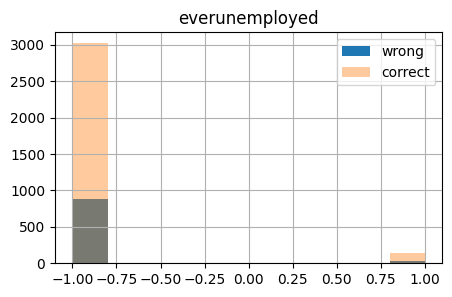

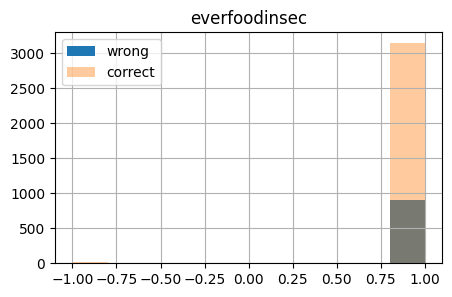

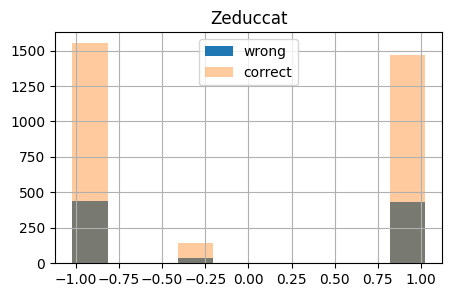

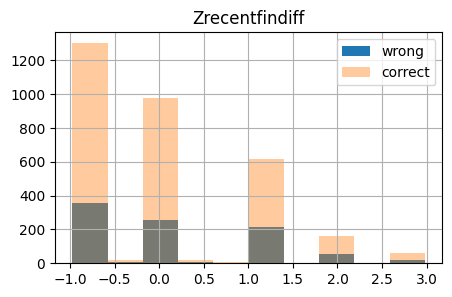

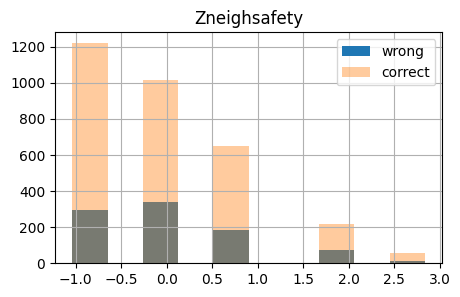

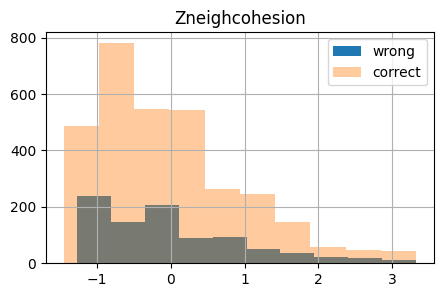

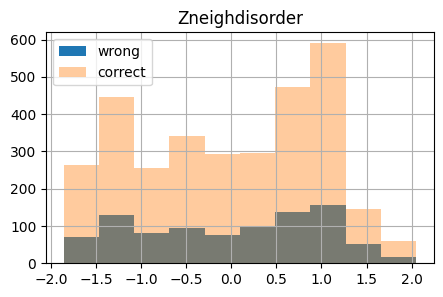

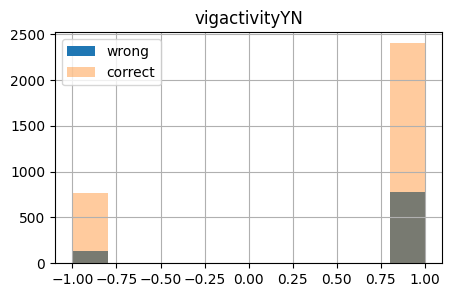

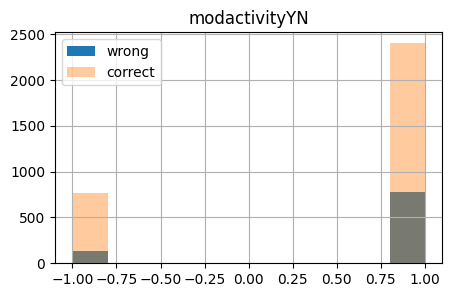

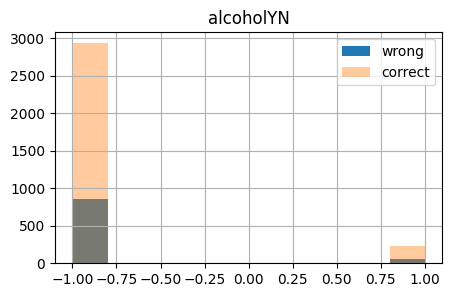

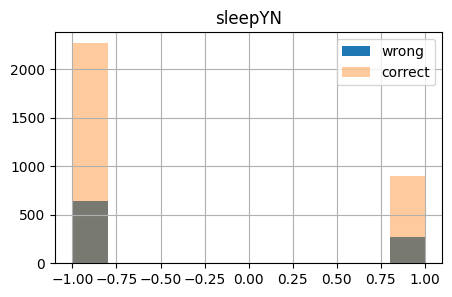

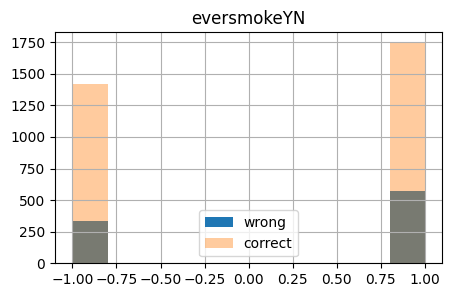

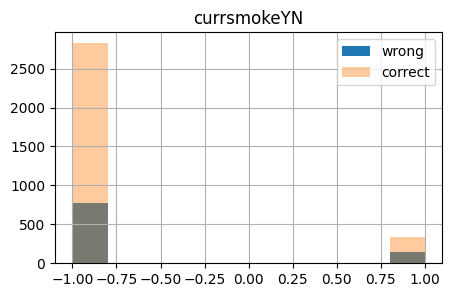

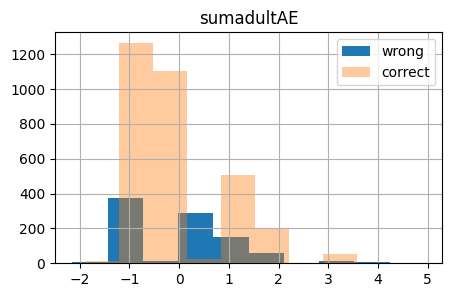

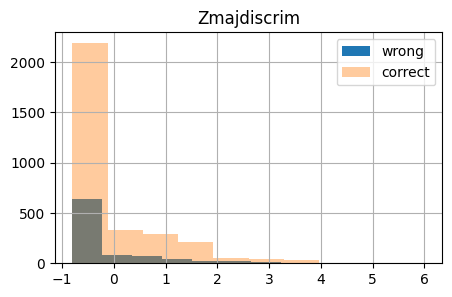

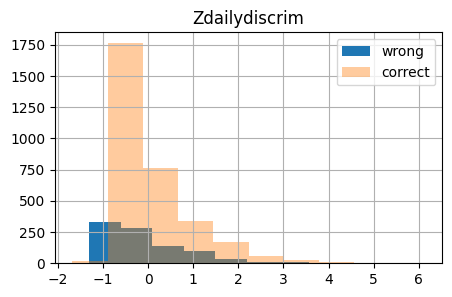

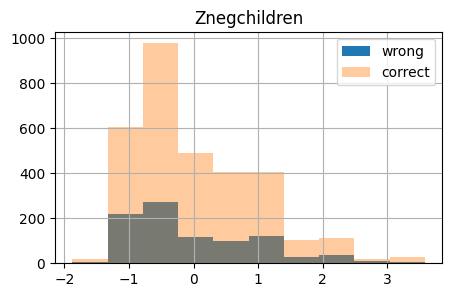

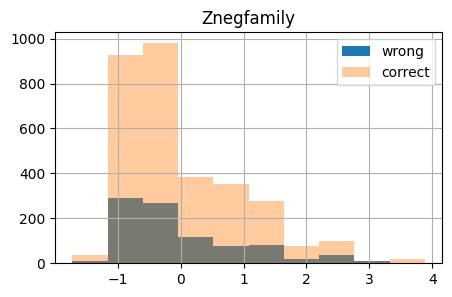

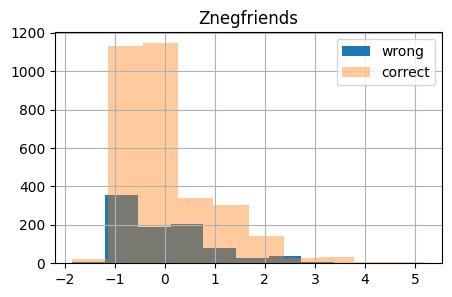

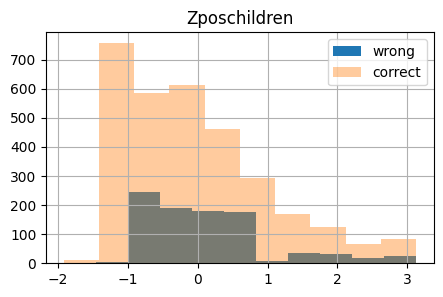

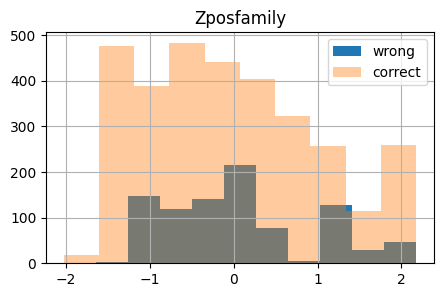

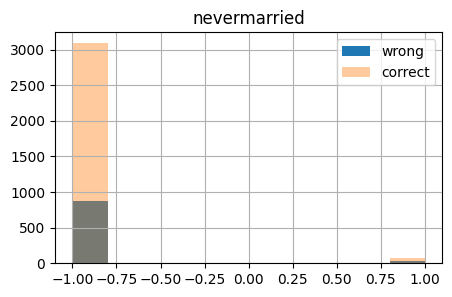

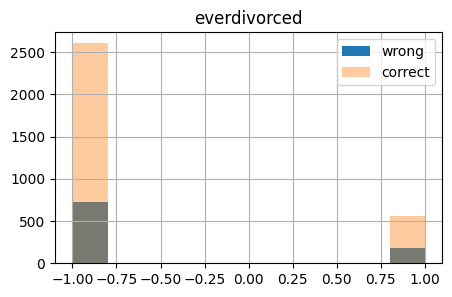

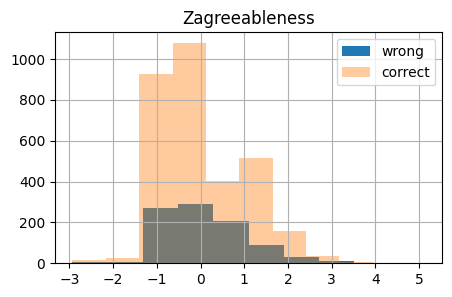

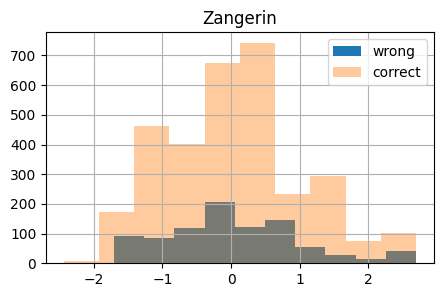

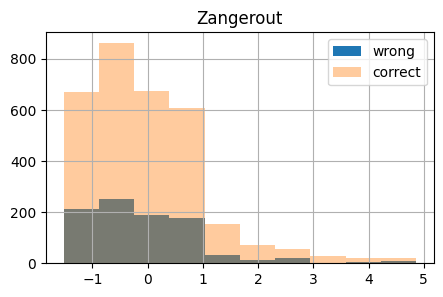

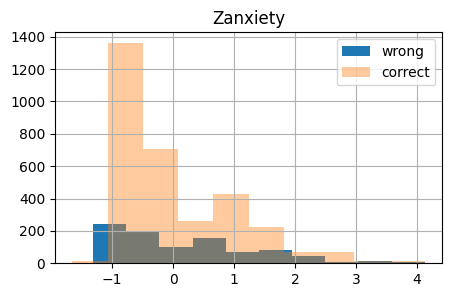

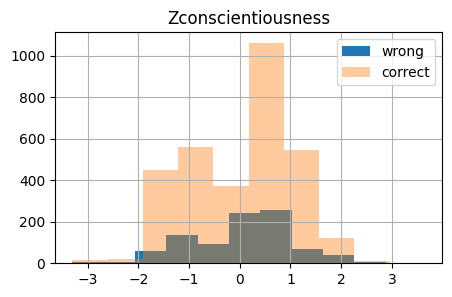

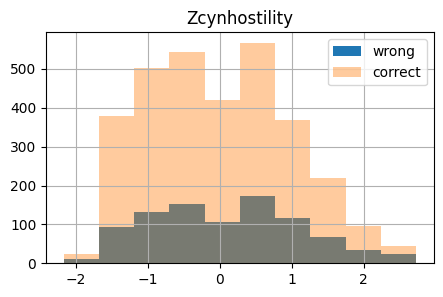

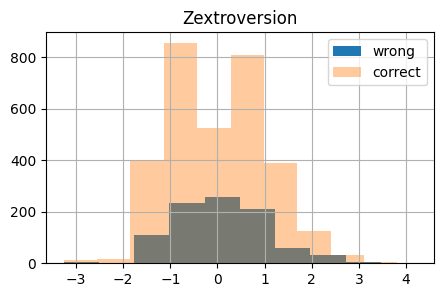

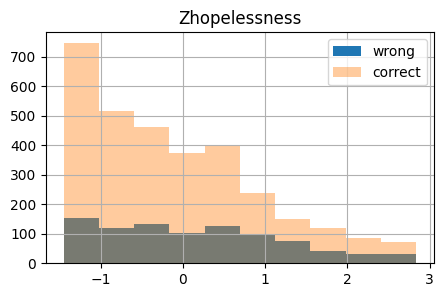

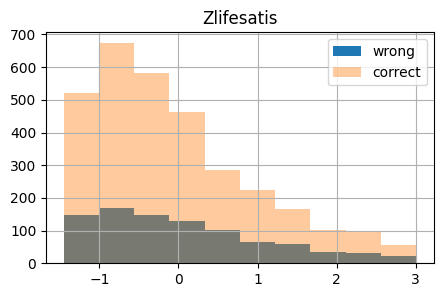

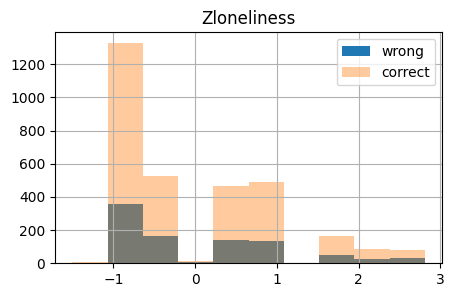

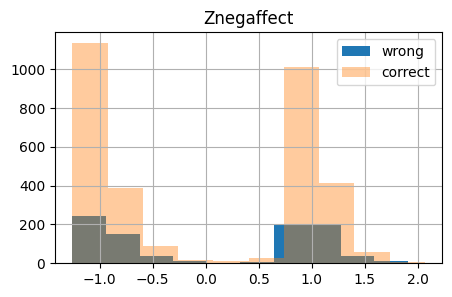

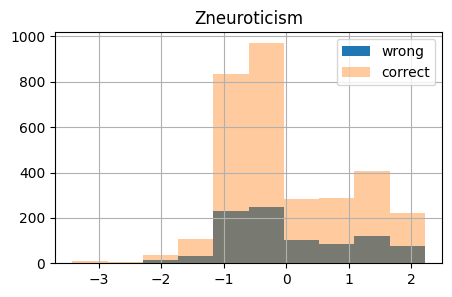

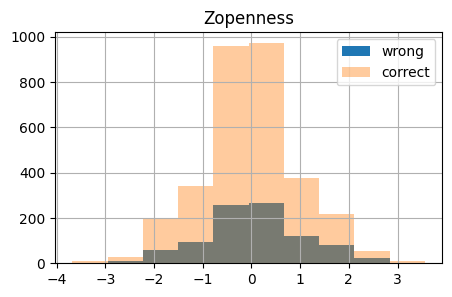

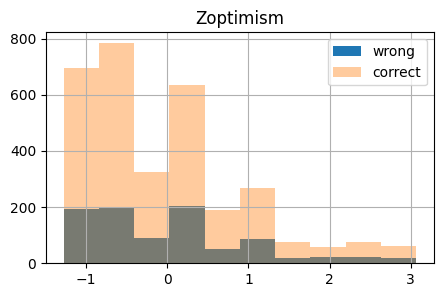

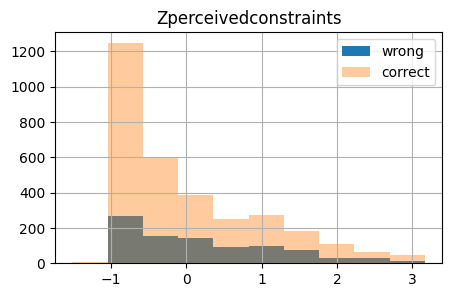

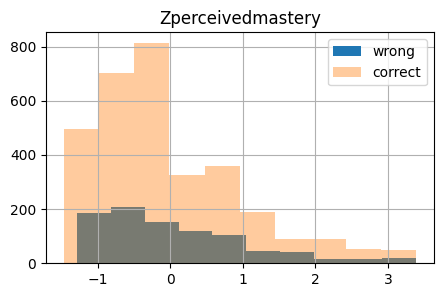

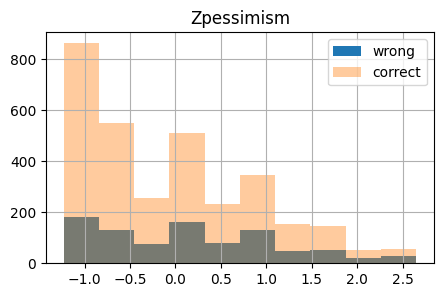

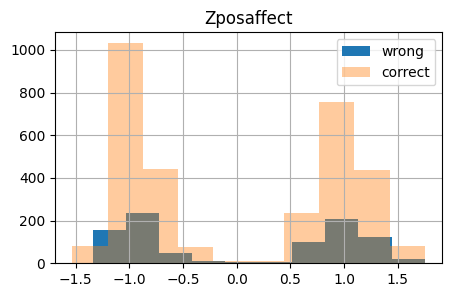

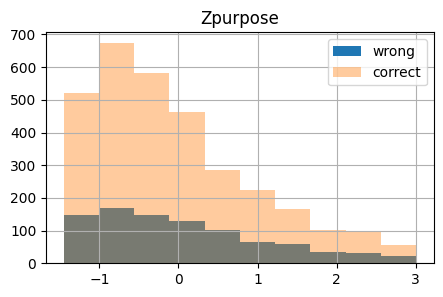

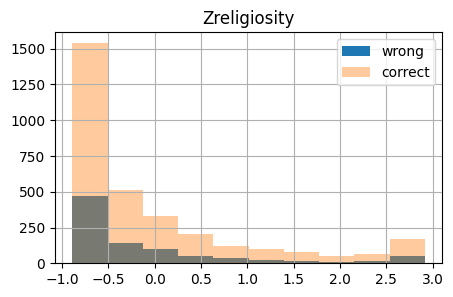

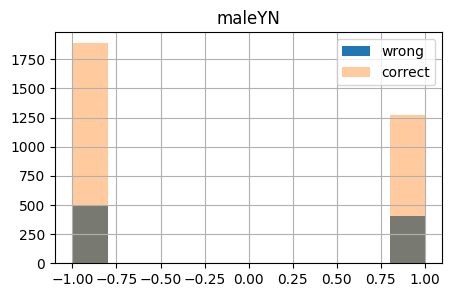

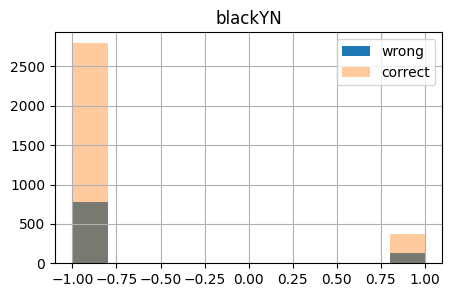

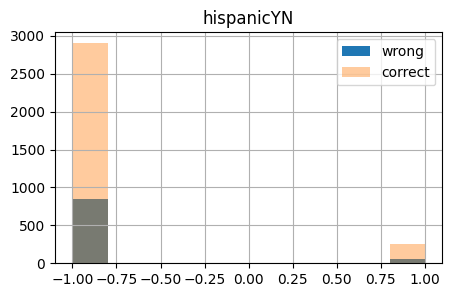

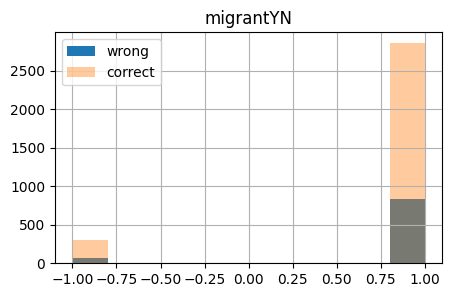

In [81]:
for column in model.X_test.columns:
    # print(column)
    # print(df_error[column].describe())
    fig,ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [5,3]
    df_error[column].hist(ax=ax,label='wrong',alpha=1)
    df_correct[column].hist(ax=ax,label='correct',alpha=0.4)
    ax.set_title(column)
    ax.legend()
    plt.show()
    

In [83]:
# false positive 
df_error_fp = df_error.loc[df_error['true']==0]
# false negative 
df_error_fn = df_error.loc[df_error['true']==1]

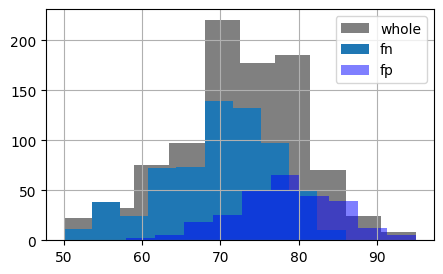

In [100]:
fig,ax = plt.subplots()
df_error.age.hist(ax=ax, label = 'whole',color='grey')
df_error_fn.age.hist(ax=ax, label = 'fn')
df_error_fp.age.hist(ax=ax, label = 'fp',alpha=0.5,color='blue')

ax.legend()

# Age dependent 

# Asymptotics


In [1]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva,ffc_rsquare,efron_rsquare
from src import Shap
from src import SuperLearner
import random 


model_params = params.model_params


## Superlearner Version 

see the single .py file named 'Asymp_SL.py' in folder 'src'


In [11]:
# graphs 
import os 
seeds = [1981236101, 56317909029, 91833472504,6588504046385,6747454181206,2069405004429]
files = [x for x in os.listdir(Path.cwd()/'sl/results') if x.startswith('asymptotics_sl_with_random_sampling_on_vars_seed_specified_')]

df = pd.DataFrame()
for file in files:
    file_num = int(file[len(file)-5:len(file)-4])
    temp = pd.read_csv(Path.cwd()/f'sl/results/{file}')
    temp['seed'] = seeds[file_num]
    #if file  == 'asymptotics_sl_with_random_sampling_on_vars_seed_specified_0.3_0.4_0.csv':
    #    temp = temp.loc[~temp['train_subset_size']== 22766]
    df = pd.concat([df,temp],axis=0)
    del(temp)


df_avg = df.groupby(['var_num','train_subset_size']).mean()
df_avg.reset_index(inplace=True)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


### graph with only sample size in the x-axis

 here we want to plot the asymptotics graph for the full set of the variables, only subsetting the trainining set size 

In [14]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_avf_on_size = df_avg.loc[df_avg['var_num']==26,]


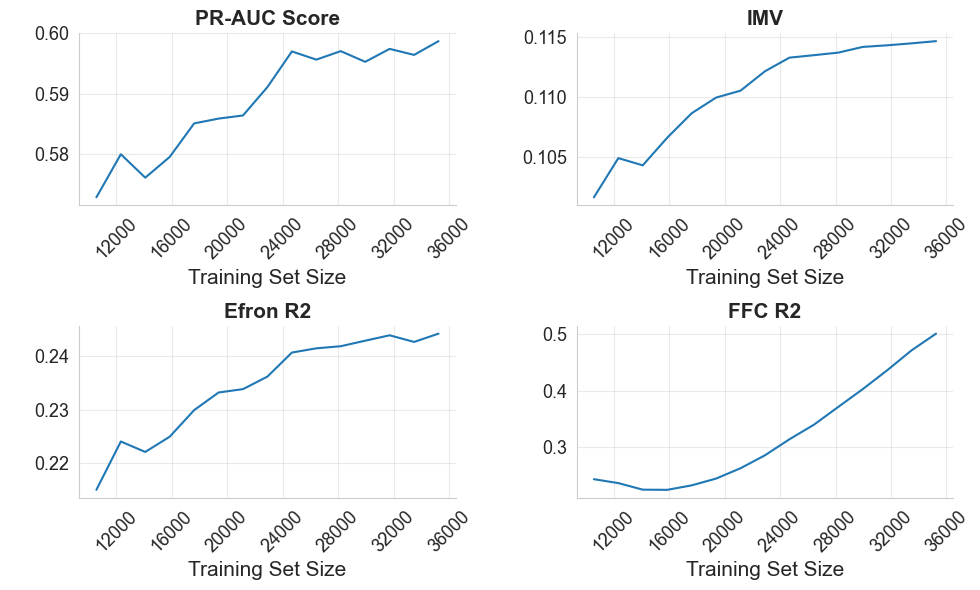

In [26]:
fig, axis = plt.subplots(2, 2)

fontsize_ticks = 13
fontsize_labels = 15
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)
plt.rcParams['figure.figsize'] = [10, 6]

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917]
count = 0
columns = ['test_pr_auc','test_imv_r2','test_efron_r2','test_ffc_r2']

ploted_col_dict = {'test_efron_r2': 'Efron R2',
                   'test_pr_auc': 'PR-AUC Score',
                   'test_ffc_r2': 'FFC R2',
                   'test_imv_r2': 'IMV'}


sns.set_style("whitegrid")
for (m, n), subplot in np.ndenumerate(axis):
    metric = columns[count]
    
    sns.lineplot(data=df_avf_on_size, x='train_subset_size',y=metric, ax=axis[m, n])

    axis[m, n].set_ylabel(' ',fontsize = fontsize_labels)
    axis[m, n].set_xlabel('Training Set Size',fontsize = fontsize_labels)
    axis[m, n].set_title(ploted_col_dict[metric],size=15,weight="bold")  # , size=fontsize_labels)

    # set ticks
    axis[m, n].tick_params(axis='x', rotation=45)

    
    axis[m, n].xaxis.set_major_locator(plt.MaxNLocator(8))

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    axis[m, n].spines['top'].set_visible(False)
    axis[m, n].spines['right'].set_visible(False)
    axis[m, n].grid(axis='both', alpha=0.4)
    axis[m, n].set_axisbelow(True)


    count += 1
fig.tight_layout()

plt.savefig(Path.cwd()/'graphs/model_outputs/asymptotics_sl_full_var.pdf')


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.


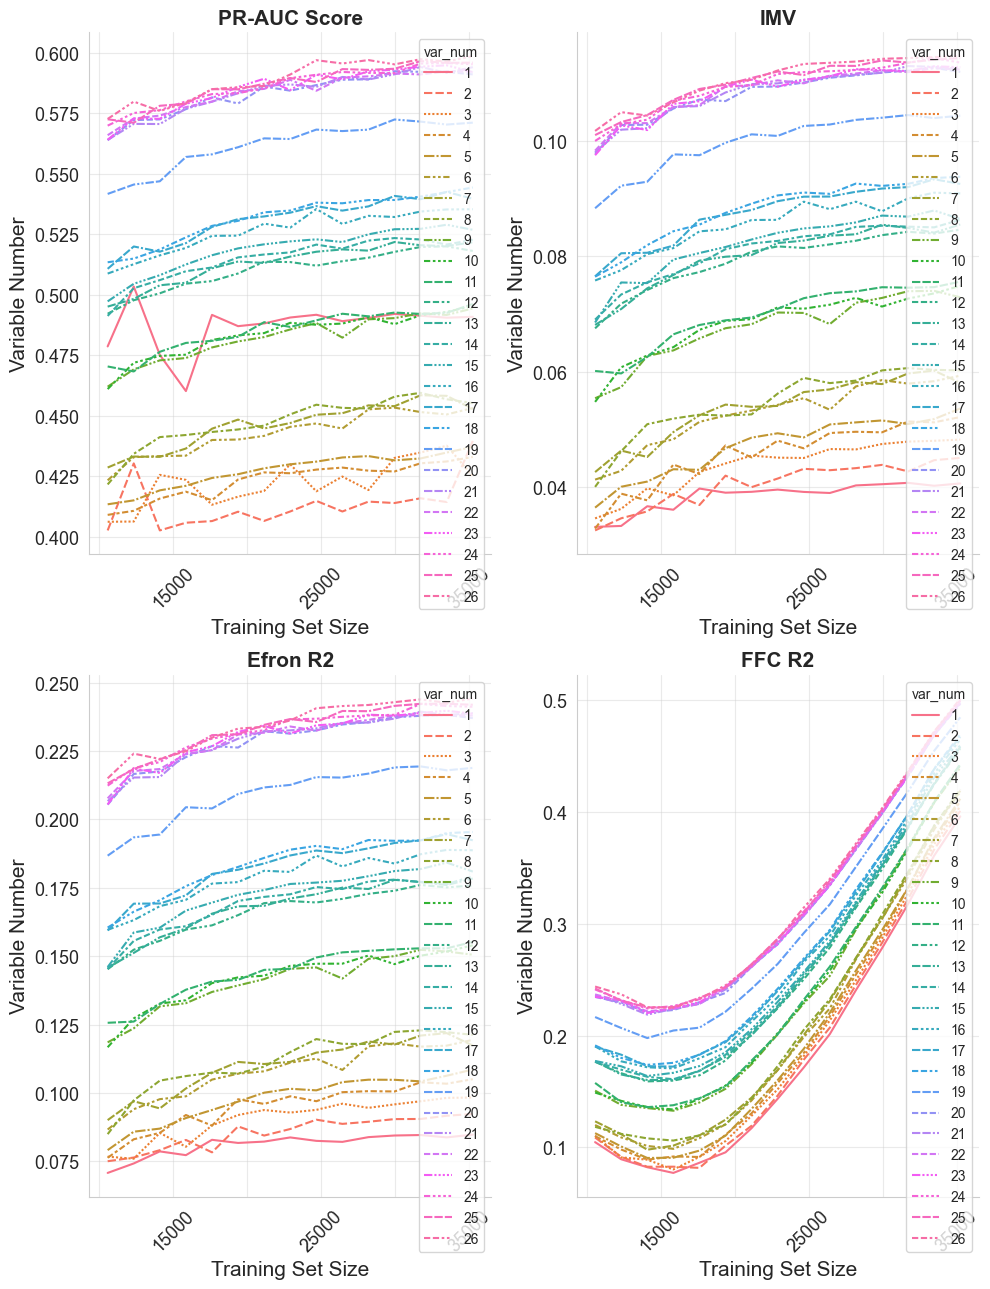

In [20]:



ploted_col_dict = {'test_efron_r2': 'Efron R2', 
                        'test_pr_auc': 'PR-AUC Score', 
                        'test_ffc_r2': 'FFC R2', 
                        'test_imv_r2': 'IMV'} 
      
      
fig, axis = plt.subplots(2, 2) 
fontsize_ticks = 13 
fontsize_labels = 15 
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99) 
plt.rcParams['figure.figsize'] = [10, 13] 

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917] 
count = 0 
columns = ['test_pr_auc','test_imv_r2','test_efron_r2','test_ffc_r2'] 
for (m, n), subplot in np.ndenumerate(axis): 
    metric = columns[count] 
    pivot_table = df_avg.pivot('train_subset_size','var_num',  metric) 
    sns.lineplot(pivot_table, ax=axis[m, n]) 
    axis[m, n].set_ylabel('Variable Number',fontsize = fontsize_labels) 
    axis[m, n].set_xlabel('Training Set Size',fontsize = fontsize_labels) 
    axis[m, n].set_title(ploted_col_dict[metric],size=15,weight="bold" )  # , size=fontsize_labels) 

 # set ticks 

    axis[m, n].tick_params(axis='x', rotation=45) 

    every_nth = 2 
    for nth, label in enumerate(axis[m, n].xaxis.get_ticklabels()): 
        if nth % every_nth != 0: 
            label.set_visible(False) 

 # axis[m, n].xaxis.set_major_locator(plt.MaxNLocator(8)) 

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks) 
    axis[m, n].spines['top'].set_visible(False) 
    axis[m, n].spines['right'].set_visible(False) 
    axis[m, n].grid(axis='both', alpha=0.4) 
    axis[m, n].set_axisbelow(True) 



    count += 1 
fig.tight_layout() 

plt.savefig(Path.cwd()/'graphs/model_outputs/asymptotics_sl_line_look.pdf')

## Figure 3: predictive asymptotics

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.


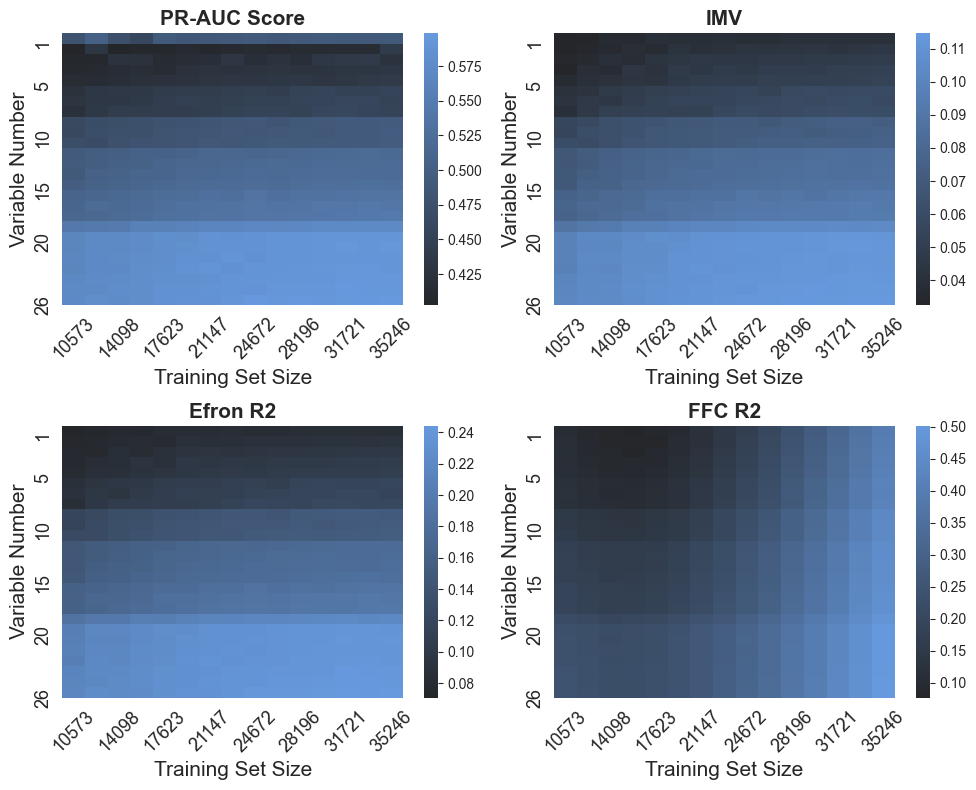

In [22]:

# plot
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

columns = []
for column in df.columns:
    if 'test' in column:
        columns.append(column)

df_to_plot = df_avg.drop_duplicates(subset=['train_subset_size', 'var_num']).copy()
df_to_plot.reset_index(inplace=True,drop=True)


columns.remove('test_f1_score')
columns.remove('test_pr_no_skill')
columns.remove('test_auc_score')
columns.remove('test_briern_r2')

ploted_col_dict = {'test_efron_r2': 'Efron R2',
                   'test_pr_auc': 'PR-AUC Score',
                   'test_ffc_r2': 'FFC R2',
                   'test_imv_r2': 'IMV'}


fig, axis = plt.subplots(2, 2)
fontsize_ticks = 13
fontsize_labels = 15
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)
plt.rcParams['figure.figsize'] = [10, 13]

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917]
count = 0
columns = ['test_pr_auc','test_imv_r2','test_efron_r2','test_ffc_r2']
for (m, n), subplot in np.ndenumerate(axis):
    metric = columns[count]
    pivot_table = df_to_plot.pivot('var_num', 'train_subset_size', metric)
    sns.heatmap(pivot_table, ax=axis[m, n], cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True))

    axis[m, n].set_ylabel('Variable Number',fontsize = fontsize_labels)
    axis[m, n].set_xlabel('Training Set Size',fontsize = fontsize_labels)
    axis[m, n].set_title(ploted_col_dict[metric],size=15,weight="bold")  # , size=fontsize_labels)

    # set ticks
    axis[m, n].set_yticks([1, 5, 10, 15, 20, 26])
    axis[m, n].set_yticklabels([1, 5, 10, 15, 20, 26])
    axis[m, n].tick_params(axis='x', rotation=45)

    every_nth = 2
    for nth, label in enumerate(axis[m, n].xaxis.get_ticklabels()):
        if nth % every_nth != 0:
            label.set_visible(False)

    # axis[m, n].xaxis.set_major_locator(plt.MaxNLocator(8))

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    axis[m, n].spines['top'].set_visible(False)
    axis[m, n].spines['right'].set_visible(False)
    axis[m, n].grid(axis='both', alpha=0.4)
    axis[m, n].set_axisbelow(True)



    count += 1
fig.tight_layout()

plt.savefig(Path.cwd()/'graphs/model_outputs/asymptotics_sl.pdf')

# seed 

## Performance Plot

In [3]:
from src import seed 

In [ ]:
# perform the seed analysis and store the result in "Path.cwd()/'results/10000seed_comb_model_performance.csv'"
seed.seed_analysis()

In [ ]:

comb_type = 3
domain_name = 'combination_all'
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=comb_type)
model_params['var_dict']['dataset']='Datasource'

df_seed_selection_lst=pd.DataFrame(columns=['seed','model','imv','roc-auc','pr-auc','f1','efron_r2','ffc_r2','IP'])
df_seed_shap_performance_recorder = pd.DataFrame(columns = ['seed','model']+model_params['domain_dict'][domain_name])

count = 0
while count < 10000:
    seed = random.randint(1, 1000000000)
    model_selection = 'lgb'

    model_params['random_state'] = seed
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb', train_subset_size=1, order=0)

    evas = metric(model)

    temp = pd.DataFrame({'seed': seed, 'model': model_selection,
                         'imv': evas.imv, 'roc-auc': evas.auc_score,
                         'pr-auc': evas.pr_auc, 'f1': evas.pr_f1,
                         'efron_r2': evas.efron_rsquare, 'ffc_r2': evas.ffc_r2, 'IP': evas.pr_no_skill}, index=[0])
    df_seed_selection_lst.loc[len(df_seed_selection_lst),] = temp.loc[0,]

    # shap zone
    shap_values_test, shap_dict = Shap.shap_values_and_dict(model)

    # store the mean absolute shap value for each variable in a dictionary
    if len(shap_values_test.shape) == 3:
        shap_values_test.values = shap_values_test.values[:, :, 1]
    shap_dict = {}
    i = 0
    while i < shap_values_test.values.shape[1]:
        sum_shap = 0
        for m in shap_values_test.values[:, i]:
            sum_shap += np.abs(m)
        shap_dict[shap_values_test.feature_names[i]] = sum_shap / shap_values_test.values.shape[0]
        i += 1
    shap_dict['seed'] = seed
    shap_dict['model'] = model_selection
    temp_shap = pd.DataFrame(shap_dict, index=[0])
    df_seed_shap_performance_recorder.loc[len(df_seed_shap_performance_recorder),] = temp_shap.loc[0,]

    del model, evas
    # rest zone
    if count % 100 == 0:
        print(f'now seed is {seed} and we take 10s rest')
        print(f'\n{model_selection} and seed is {seed}, count={count}')
        df_seed_selection_lst.to_csv(Path.cwd() / f'results/10000seed_comb_model_performance_comb_{comb_type}.csv', index=False)
        df_seed_shap_performance_recorder.to_csv(Path.cwd() / f'results/10000seed_comb_shap_values_comb_{comb_type}.csv', index=False)

        time.sleep(10)
    count += 1

df_seed_selection_lst.to_csv(Path.cwd() / f'results/10000seed_comb_model_performance_comb_{comb_type}.csv', index=False)
df_seed_shap_performance_recorder.to_csv(Path.cwd() / f'results/10000seed_comb_shap_values_comb_{comb_type}.csv', index=False)


## Figure 4: Seed 

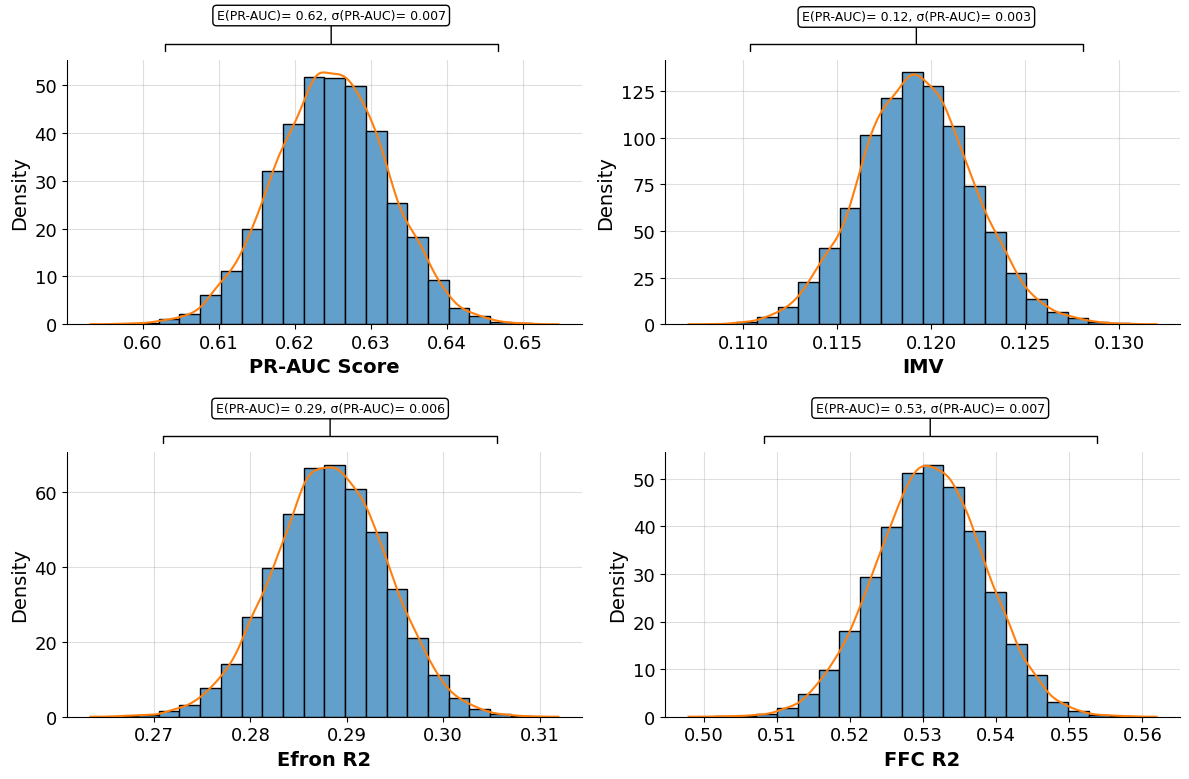

In [32]:
import time
import random
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric
from src import Shap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')


def draw_brace(ax, mean, y, text):
    brace_width = 0.5
    text_pos_y = 1.08 * y + brace_width

    # Horizontal part (curly brace)
    ax.annotate('', xy=(mean, y), xycoords='data',
                xytext=(mean, text_pos_y), textcoords='data',
                arrowprops=dict(arrowstyle=f']-[, widthB=12, lengthB=0.5,angleB=0,widthA=0,lengthA=0', ),
                annotation_clip=False)

    # Text with expectation and variance
    ax.text(mean, text_pos_y, text, ha='center', va='bottom', fontsize=9,
            bbox=dict(boxstyle='Round', fc='white'))

    
df_eval = df_seed_selection_lst
fig, ax = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [12, 8]
count = 0
colums = ['pr-auc', 'imv', 'efron_r2', 'ffc_r2']
column_dict = {'roc-auc': 'ROC-AUC Score', 'pr-auc': 'PR-AUC Score', 'f1': 'F1', 'efron_r2': 'Efron R2', 'ffc_r2': 'FFC R2', 'imv': 'IMV'}
fig.subplots_adjust(left=0.09, top=0.98, bottom=0.06, right=0.95)

# colors = ['#001c54', '#E89818']

letter_fontsize = 15
label_fontsize = 13
for (m, n), subplot in np.ndenumerate(ax):
    
    sns.distplot(df_eval[colums[count]],
                 hist_kws={'facecolor': colors['blue'], 'edgecolor': 'k', 'alpha':1},
                 kde_kws={'color': colors['orange']}, ax=ax[m, n], bins=20)
    # ax[m,n].hist(df_eval[colums[count]],color=color_blue,alpha=0.75,bins=30,edgecolor='black')
    ax[m, n].set_xlabel(column_dict[colums[count]], fontsize=label_fontsize + 1, weight='bold')
    ax[m, n].set_ylabel('Density', fontsize=label_fontsize + 1)
    ax[m, n].set_axisbelow(True)
    ax[m, n].grid(alpha=0.4,zorder=0)
    ax[m, n].tick_params(axis='both', which='major', labelsize=label_fontsize)

    # annotation part

    stats_text = f"E(PR-AUC)= {df_eval[colums[count]].mean():.2f}, \u03C3(PR-AUC)= {df_eval[colums[count]].std():.3f}"

    draw_brace(ax[m, n],
               df_eval[colums[count]].mean(),
               ax[m, n].get_ylim()[1] * 1.05,
               stats_text)

    count += 1
    ax[m, n].spines['top'].set_visible(False)
    ax[m, n].spines['right'].set_visible(False)

fig.tight_layout()
# plt.show()

plt.savefig(Path.cwd() / 'graphs/model_outputs/seed_lgb_10000_seed_distributions.pdf')


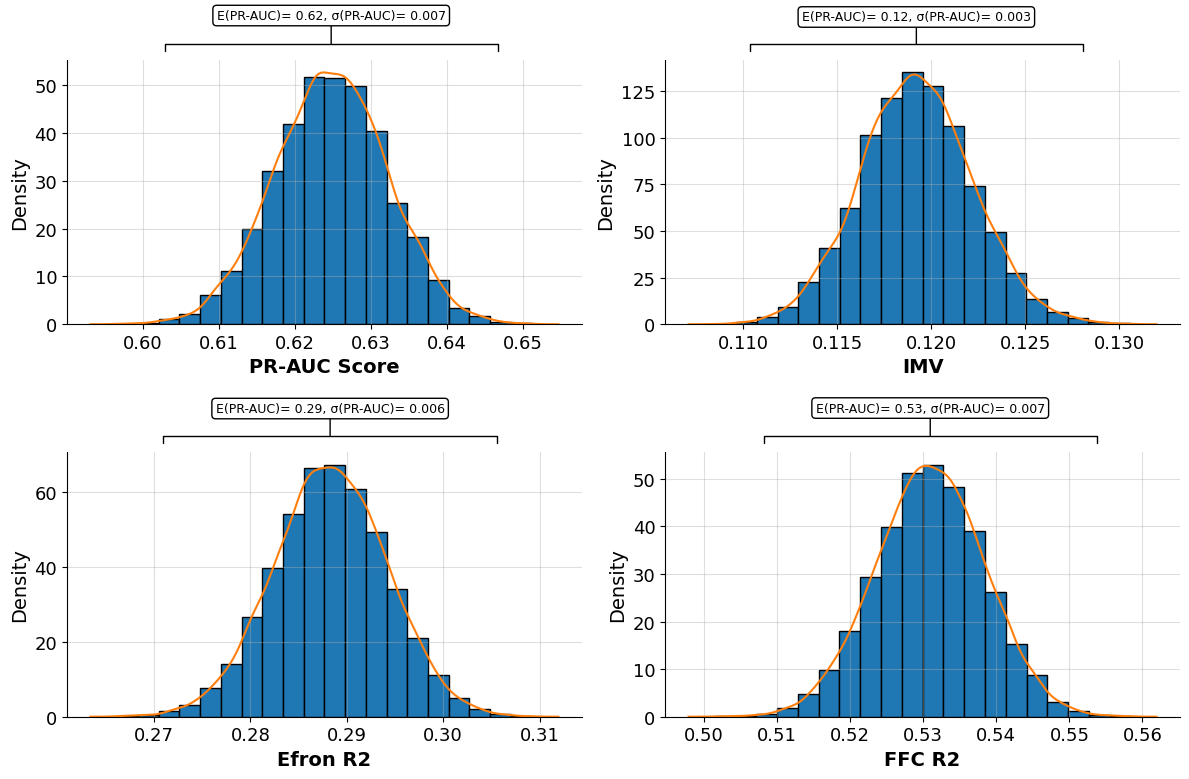

In [6]:
df_seed_selection_lst=pd.read_csv(Path.cwd()/'results/10000seed_comb_model_performance.csv')
seed.seed_plot(df_seed_selection_lst)

## Table 2 

In [297]:
df_table_2 = pd.DataFrame(columns=['metric','mean','min','max','standard deviation'])
for metric in ['pr-auc','imv','efron_r2','ffc_r2']:
    df_table_2.loc[len(df_table_2),]=[metric,
                                      df_seed_selection_lst[metric].mean(),
                                      df_seed_selection_lst[metric].min(), 
                                      df_seed_selection_lst[metric].max(), 
                                      df_seed_selection_lst[metric].std()]

In [305]:
# df_table_2 = pd.DataFrame(columns=['metric','mean','min','max','standard deviation'])
columns =list(df_seed_shap_performance_recorder.columns)
columns.remove('seed')
columns.remove('model')
              
for column in columns:
    if df_seed_shap_performance_recorder[column].mean()>=0.1:
        df_table_2.loc[len(df_table_2),]=[column,
                                          df_seed_shap_performance_recorder[column].mean(),
                                          df_seed_shap_performance_recorder[column].min(), 
                                          df_seed_shap_performance_recorder[column].max(), 
                                          df_seed_shap_performance_recorder[column].std()]


In [306]:
df_table_2

metric      mean       min       max standard deviation
0         pr-auc  0.624782  0.596617  0.651167           0.007409
1            imv  0.119216  0.108524  0.130572           0.002988
2       efron_r2  0.288267  0.266192  0.309161            0.00587
3         ffc_r2  0.530961  0.501446  0.558391           0.007451
4    currsmokeYN  0.140681  0.090471  0.186679           0.012491
5            age  0.964599  0.926125  1.004025           0.010889
6  modactivityYN  0.115472  0.070729  0.149918            0.01011
7         maleYN  0.229235   0.19567   0.27235           0.010056

In [313]:
replace_dic={'pr-auc':"PR-AUC",
 'imv':"IMV",
 'efron_r2':"Efron $R^2$",
 'ffc_r2':"FFC $R^2$",
 'currsmokeYN':'Current Smoker',
 'age':'Age',
 'modactivityYN':"Low/No Moderate Activity",
 'maleYN':'Male'}
for eva in df_table_2.metric:
    print("& {} & {} & {} & {} & {} \\\\".format(replace_dic[eva],
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'mean'].values[0],3),
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'min'].values[0],3),
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'max'].values[0],3),
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'standard deviation'].values[0],3)))

& PR-AUC & 0.625 & 0.597 & 0.651 & 0.007 \\
& IMV & 0.119 & 0.109 & 0.131 & 0.003 \\
& Efron $R^2$ & 0.288 & 0.266 & 0.309 & 0.006 \\
& FFC $R^2$ & 0.531 & 0.501 & 0.558 & 0.007 \\
& Current Smoker & 0.141 & 0.09 & 0.187 & 0.012 \\
& Age & 0.965 & 0.926 & 1.004 & 0.011 \\
& Low/No Moderate Activity & 0.115 & 0.071 & 0.15 & 0.01 \\
& Male & 0.229 & 0.196 & 0.272 & 0.01 \\


In [315]:
for eva in df_table_2.metric:
    print("{}".format(replace_dic[eva],round(df_table_2.loc[(df_table_2['metric']==eva),'max'].values[0]-df_table_2.loc[(df_table_2['metric']==eva),'min'].values[0],3)))
   

PR-AUC 0.055
IMV 0.022
Efron $R^2$ 0.043
FFC $R^2$ 0.057
Current Smoker 0.096
Age 0.078
Low/No Moderate Activity 0.079
Male 0.077
